# Summarize and aggregate susceptibility scores across all queries

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
from typing import Dict, List, Set, Union, Tuple
import yaml
from ast import literal_eval

import json
import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import font_manager as fm, pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/scratch/tmp.53685048.kevidu/ipykernel_474694/3431679233.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [4]:
from utils import construct_paths_and_dataset_kwargs, infer_context_type
from analysis_helpers import (
    compute_ttest_scores_dfs,
    save_ttest_df_to_json,
    count_open_closed_sig_group_match,
    count_num_significant_queries,
    combine_open_and_closed_dfs,
    write_to_latex_test_results_by_qid,
    write_to_latex_test_sus_and_per_results_by_qid,
    explode_val_df_per_qe,
    convert_test_results_dict_to_df,
    convert_test_results_dict_to_sig_proportion_df,
    build_mean_effect_sz_df,
    get_param_size,
    get_test_results_and_plot_per_model,
    plot_prop_queries_significant_per_model,
    plot_effect_sz_per_model,
)

#b40426


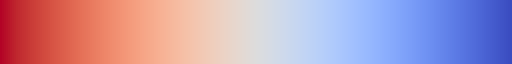

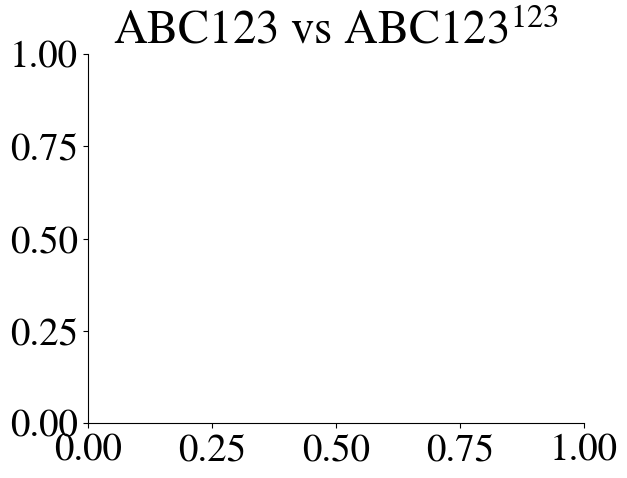

In [5]:
from analysis.mpl_styles import *
import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

open_closed_colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
comparison_colormap = {
    "Familiar vs unfamiliar entities": palette[0],
    "Assertive vs base contexts": palette[1],
    "Negation vs base contexts": palette[3],
    "Relevant vs irrelevant contexts": palette[5],
}

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

cm = sns.color_palette("coolwarm_r", as_cmap=True)
cm.set_bad(cm(-np.inf))
print(matplotlib.colors.to_hex(cm(-np.inf)))
cm

In [6]:
##################
### Parameters ###
##################

# Data parameters
RAW_DATA_PATH = "data/YagoECQ/yago_qec copy.json"

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis", "summarize", "across-models"]
LOG_DATASETS = True

### Construct dataframes for analysis

In [7]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [8]:
query_ids = list(yago_qec.keys())

In [9]:
analysis_dir = "analysis/summarize/across_models"
os.makedirs(analysis_dir, exist_ok=True)

In [10]:
dataset_names_and_rdps = [("YagoECQ", RAW_DATA_PATH)]
seeds = [11]
model_id_and_quantize_tuples = [
    ("EleutherAI/pythia-70m-deduped", False, 32),
    ("EleutherAI/pythia-410m-deduped", False, 32),
    ("EleutherAI/pythia-1.4b-deduped", False, 32),
    ("EleutherAI/pythia-2.8b-deduped", False, 16),
    ("EleutherAI/pythia-6.9b-deduped", False, 16),
    # ("EleutherAI/pythia-6.9b-deduped", True, 16),
    ("EleutherAI/pythia-12b-deduped", True, 16),
]
max_contexts = [600]
max_entities = [100]
query_ids = list(yago_qec.keys())
# query_ids = ["http://schema.org/founder"]

ent_selection_fns = [
    "top_entity_uri_degree",
    "top_entity_namesake_degree",
    "random_sample",
]

entity_types = json.dumps(
    ["entities", "gpt_fake_entities"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
query_types = json.dumps(
    ["closed", "open"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
context_types = json.dumps(["assertive", "base", "negation"], separators=(",", ":"))

answer_map = dict()
# answer_map = {0: [" No", " no", " NO", "No", "no", "NO"], 1: [" Yes", " yes", " YES", "Yes", "yes", "YES"]}

cap_per_type = False
ablate = False
deduplicate_entities = True
uniform_contexts = True
overwrite = False


def convert_answer_map_to_tokens(
    model_id: str, answer_map: Dict[int, List[str]]
) -> str:
    answer_map_token_ids = dict()
    if answer_map:
        tokenizer = AutoTokenizer.from_pretrained(
            model_id,
            padding_side="left",
        )

        for k, v in answer_map.items():
            list_of_token_ids: List[List[str]] = tokenizer(v)["input_ids"]
            valid_token_ids = []
            for token_id in list_of_token_ids:
                if len(token_id) == 1:
                    valid_token_ids.append(token_id[0])
                else:
                    print(
                        f"tokenizer tokenized an answer map token into multiple tokens ({token_id}), which is invalid input."
                    )
            answer_map_token_ids[k] = valid_token_ids
        #     answer_map_token_ids = {
        #         k: [x[0] for x in tokenizer(v)["input_ids"] if len(x) == 1],
        #         for k, v in answer_map.items()
        #     }
    res = json.dumps(answer_map_token_ids, separators=(",", ":"))
    print(res)
    return res


df_dict = []
for ds, rdp in dataset_names_and_rdps:
    for seed in seeds:
        for model_id, do_quantize, bs in tqdm(model_id_and_quantize_tuples):
            answer_map_in_tokens = convert_answer_map_to_tokens(model_id, answer_map)
            for qid in tqdm(query_ids):
                for mc in max_contexts:
                    for me in max_entities:
                        for es in ent_selection_fns:
                            dict_vals = dict(
                                DATASET_NAME=ds,
                                RAW_DATA_PATH=rdp,
                                SEED=seed,
                                MODEL_ID=model_id,
                                LOAD_IN_8BIT=do_quantize,
                                QUERY_ID=qid,
                                MAX_CONTEXTS=mc,
                                MAX_ENTITIES=me,
                                CAP_PER_TYPE=cap_per_type,
                                ABLATE_OUT_RELEVANT_CONTEXTS=ablate,
                                DEDUPLICATE_ENTITIES=deduplicate_entities,
                                UNIFORM_CONTEXTS=uniform_contexts,
                                ENTITY_SELECTION_FUNC_NAME=es,
                                OVERWRITE=False,
                                ENTITY_TYPES=json.loads(entity_types),
                                QUERY_TYPES=json.loads(query_types),
                                CONTEXT_TYPES=json.loads(context_types),
                                ANSWER_MAP=json.loads(answer_map_in_tokens)
                                if json.loads(answer_map_in_tokens)
                                else None,
                            )
                            (
                                data_dir,
                                input_dir,
                                entities_path,
                                contexts_path,
                                queries_path,
                                answers_path,
                                val_data_path,
                                model_dir,
                                results_dir,
                                val_results_path,
                                mr_results_path,
                                data_id,
                                _,
                                DATASET_KWARGS_IDENTIFIABLE,
                            ) = construct_paths_and_dataset_kwargs(**dict_vals)
                            if os.path.isfile(val_results_path):
                                res = pd.read_csv(
                                    val_results_path,
                                    index_col=0,
                                    converters={
                                        # "contexts": literal_eval,
                                        "entity": literal_eval,
                                    },
                                )
                                closed_qfs = yago_qec[qid]["query_forms"]["closed"]
                                open_qfs = yago_qec[qid]["query_forms"]["open"]

                                res.loc[
                                    res["query_form"].isin(closed_qfs), "query_type"
                                ] = "closed"
                                res.loc[
                                    res["query_form"].isin(open_qfs), "query_type"
                                ] = "open"
                                res.loc[
                                    res["entity"].isin(
                                        [
                                            (x,)
                                            for x in yago_qec[qid]["gpt_fake_entities"]
                                        ]
                                    ),
                                    "entity_type",
                                ] = "gpt_fake_entities"
                                res.loc[
                                    res["entity"].isin(
                                        [(x,) for x in yago_qec[qid]["entities"]]
                                    ),
                                    "entity_type",
                                ] = "entities"
                                res["entity_classes"] = res["q_id"].apply(
                                    lambda x: yago_qec[qid]["entity_types"]
                                )
                                res["entity"] = res["entity"].apply(lambda x: x[0])
                                scores: List[dict] = res[
                                    [
                                        "entity",
                                        "answer",
                                        "query_form",
                                        "entity_type",
                                        "query_type",
                                        "entity_classes",
                                        "susceptibility_score",
                                        "contexts",
                                        "persuasion_scores_kl",
                                    ]
                                ].to_dict("records")
                                df_dict += [{**dict_vals, **d} for d in scores]

  0%|          | 0/6 [00:00<?, ?it/s]

{}


 17%|█▋        | 1/6 [01:42<08:34, 102.91s/it]

{}


 33%|███▎      | 2/6 [03:28<06:58, 104.53s/it]

{}


 50%|█████     | 3/6 [05:07<05:05, 101.99s/it]

{}


 67%|██████▋   | 4/6 [06:47<03:22, 101.24s/it]

{}


 83%|████████▎ | 5/6 [08:29<01:41, 101.63s/it]

{}


100%|██████████| 6/6 [10:07<00:00, 101.27s/it]


In [11]:
scores_df = pd.DataFrame(df_dict)
scores_df.drop(columns=["contexts", "persuasion_scores_kl", "OVERWRITE"]).to_csv(
    os.path.join(analysis_dir, "summarized_scores_all_models.csv"), index=False
)
scores_df["ENTITY_TYPES"] = scores_df["ENTITY_TYPES"].apply(lambda x: tuple(x))
scores_df["QUERY_TYPES"] = scores_df["QUERY_TYPES"].apply(lambda x: tuple(x))
scores_df["CONTEXT_TYPES"] = scores_df["CONTEXT_TYPES"].apply(lambda x: tuple(x))
scores_df.info(), scores_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292400 entries, 0 to 292399
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATASET_NAME                  292400 non-null  object 
 1   RAW_DATA_PATH                 292400 non-null  object 
 2   SEED                          292400 non-null  int64  
 3   MODEL_ID                      292400 non-null  object 
 4   LOAD_IN_8BIT                  292400 non-null  bool   
 5   QUERY_ID                      292400 non-null  object 
 6   MAX_CONTEXTS                  292400 non-null  int64  
 7   MAX_ENTITIES                  292400 non-null  int64  
 8   CAP_PER_TYPE                  292400 non-null  bool   
 9   ABLATE_OUT_RELEVANT_CONTEXTS  292400 non-null  bool   
 10  DEDUPLICATE_ENTITIES          292400 non-null  bool   
 11  UNIFORM_CONTEXTS              292400 non-null  bool   
 12  ENTITY_SELECTION_FUNC_NAME    292400 non-nul

(None,
 Index(['DATASET_NAME', 'RAW_DATA_PATH', 'SEED', 'MODEL_ID', 'LOAD_IN_8BIT',
        'QUERY_ID', 'MAX_CONTEXTS', 'MAX_ENTITIES', 'CAP_PER_TYPE',
        'ABLATE_OUT_RELEVANT_CONTEXTS', 'DEDUPLICATE_ENTITIES',
        'UNIFORM_CONTEXTS', 'ENTITY_SELECTION_FUNC_NAME', 'OVERWRITE',
        'ENTITY_TYPES', 'QUERY_TYPES', 'CONTEXT_TYPES', 'ANSWER_MAP', 'entity',
        'answer', 'query_form', 'entity_type', 'query_type', 'entity_classes',
        'susceptibility_score', 'contexts', 'persuasion_scores_kl'],
       dtype='object'))

Optionally, filter out fake entities that appear in the training data

In [12]:
scores_df[["MODEL_ID", "LOAD_IN_8BIT"]].value_counts()

MODEL_ID                        LOAD_IN_8BIT
EleutherAI/pythia-70m-deduped   False           49200
EleutherAI/pythia-1.4b-deduped  False           48800
EleutherAI/pythia-2.8b-deduped  False           48800
EleutherAI/pythia-410m-deduped  False           48800
EleutherAI/pythia-6.9b-deduped  False           48800
EleutherAI/pythia-12b-deduped   True            48000
Name: count, dtype: int64

In [13]:
set(query_ids).difference(
    scores_df[
        (scores_df["MODEL_ID"] == "EleutherAI/pythia-6.9b-deduped")
        & (scores_df["LOAD_IN_8BIT"] == False)
    ]["QUERY_ID"].unique()
)

{'http://schema.org/gtin', 'http://schema.org/motto', 'http://schema.org/url'}

In [14]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
FAKE_ENTITY_FREQ_THRESHOLD = (
    0  # filter out any fake entities with frequency greater than this
)
# FAKE_ENTITY_FREQ_THRESHOLD = np.inf # don't filter at all
print("Pre-filtering:", len(scores_df))
df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
scores_df = scores_df[
    scores_df.apply(
        lambda x: x["entity_type"] == "entities"
        or fake_ent_freqs_dict.get(x["entity"], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
        axis=1,
    )
]

print("Post filtering:", len(scores_df))
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

Pre-filtering: 292400
Post filtering: 245024


In [15]:
scores_df["entity"].iloc[0]

'Crime and Punishment'

### Susceptibility Scores: Known vs Unknown

In [16]:
scores_per_model = scores_df.groupby("MODEL_ID")
scores_per_model = sorted(scores_per_model, key=lambda x: get_param_size(x[0]))
print(list(zip(*scores_per_model))[0])

('EleutherAI/pythia-70m-deduped', 'EleutherAI/pythia-410m-deduped', 'EleutherAI/pythia-1.4b-deduped', 'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-12b-deduped')


In [17]:
model_id, df_m = next(iter(scores_per_model))
df_m.columns

Index(['DATASET_NAME', 'RAW_DATA_PATH', 'SEED', 'MODEL_ID', 'LOAD_IN_8BIT',
       'QUERY_ID', 'MAX_CONTEXTS', 'MAX_ENTITIES', 'CAP_PER_TYPE',
       'ABLATE_OUT_RELEVANT_CONTEXTS', 'DEDUPLICATE_ENTITIES',
       'UNIFORM_CONTEXTS', 'ENTITY_SELECTION_FUNC_NAME', 'OVERWRITE',
       'ENTITY_TYPES', 'QUERY_TYPES', 'CONTEXT_TYPES', 'ANSWER_MAP', 'entity',
       'answer', 'query_form', 'entity_type', 'query_type', 'entity_classes',
       'susceptibility_score', 'contexts', 'persuasion_scores_kl'],
      dtype='object')

MODEL ID: EleutherAI/pythia-70m-deduped


100%|██████████| 123/123 [00:18<00:00,  6.50it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 0,
      "insignificant": 123
    },
    "proportion": {
      "significant (greater)": 0.0,
      "insignificant": 1.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 21,
      "insignificant": 102
    },
    "proportion": {
      "significant (greater)": 0.17073170731707318,
      "insignificant": 0.8292682926829268
    }
  }
}
MODEL ID: EleutherAI/pythia-410m-deduped


100%|██████████| 122/122 [00:18<00:00,  6.71it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 26,
      "insignificant": 96
    },
    "proportion": {
      "significant (greater)": 0.21311475409836064,
      "insignificant": 0.7868852459016393
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 34,
      "insignificant": 88
    },
    "proportion": {
      "significant (greater)": 0.2786885245901639,
      "insignificant": 0.7213114754098361
    }
  }
}
MODEL ID: EleutherAI/pythia-1.4b-deduped


100%|██████████| 122/122 [00:17<00:00,  6.87it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 47,
      "insignificant": 75
    },
    "proportion": {
      "significant (greater)": 0.38524590163934425,
      "insignificant": 0.6147540983606558
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 55,
      "insignificant": 67
    },
    "proportion": {
      "significant (greater)": 0.45081967213114754,
      "insignificant": 0.5491803278688525
    }
  }
}
MODEL ID: EleutherAI/pythia-2.8b-deduped


100%|██████████| 122/122 [00:17<00:00,  6.80it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 49,
      "insignificant": 73
    },
    "proportion": {
      "significant (greater)": 0.4016393442622951,
      "insignificant": 0.5983606557377049
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 39,
      "insignificant": 83
    },
    "proportion": {
      "significant (greater)": 0.319672131147541,
      "insignificant": 0.680327868852459
    }
  }
}
MODEL ID: EleutherAI/pythia-6.9b-deduped


100%|██████████| 122/122 [00:17<00:00,  6.79it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 57,
      "insignificant": 65
    },
    "proportion": {
      "significant (greater)": 0.4672131147540984,
      "insignificant": 0.5327868852459017
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 50,
      "insignificant": 72
    },
    "proportion": {
      "significant (greater)": 0.4098360655737705,
      "insignificant": 0.5901639344262295
    }
  }
}
MODEL ID: EleutherAI/pythia-12b-deduped


100%|██████████| 120/120 [00:17<00:00,  6.81it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 43,
      "insignificant": 77
    },
    "proportion": {
      "significant (greater)": 0.35833333333333334,
      "insignificant": 0.6416666666666667
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 67,
      "insignificant": 53
    },
    "proportion": {
      "significant (greater)": 0.5583333333333333,
      "insignificant": 0.44166666666666665
    }
  }
}


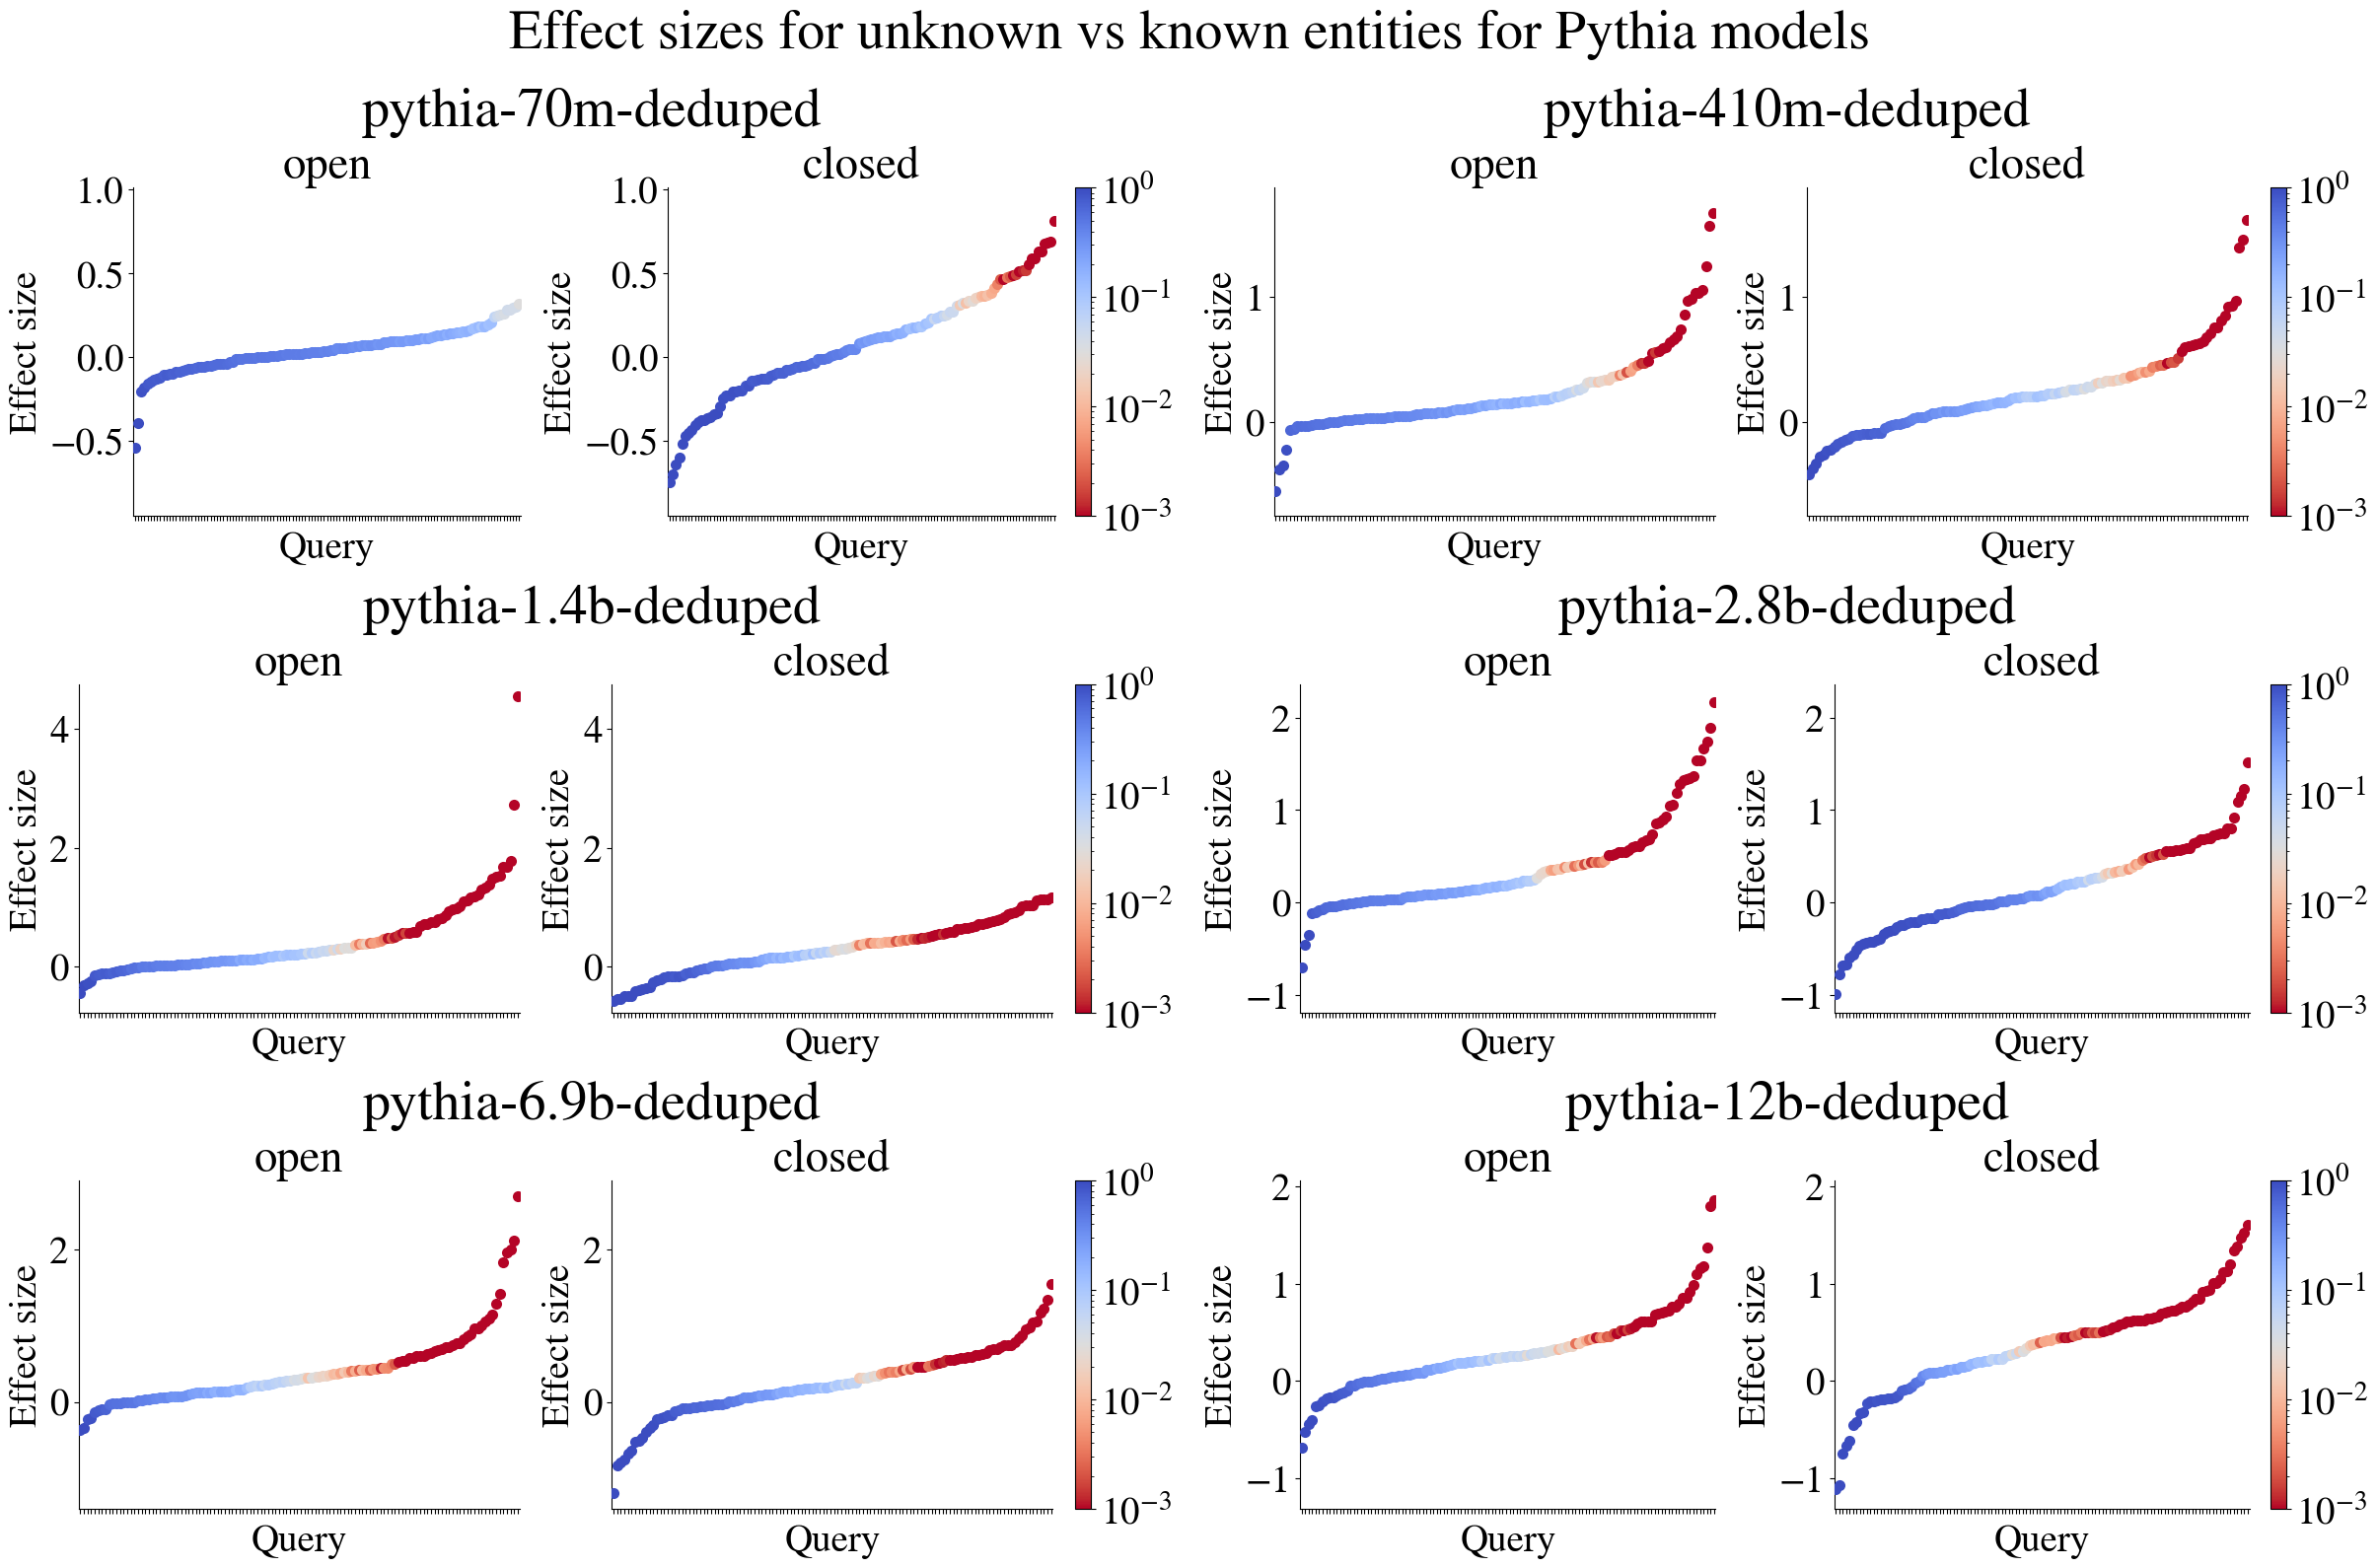

In [18]:
(
    sus_open_results_per_model,
    sus_closed_results_per_model,
    sus_test_results_per_model,
) = get_test_results_and_plot_per_model(
    scores_per_model,
    group1="gpt_fake_entities",
    group2="entities",
    score_col="susceptibility_score",
    type_col="entity_type",
    permutations=10000,
    alternative="greater",
    title="Effect sizes for unknown vs known entities for Pythia models",
    save_path=os.path.join(
        analysis_dir, "plot_sus_score_known_vs_unknown_all_models.pdf"
    ),
    cm=cm,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


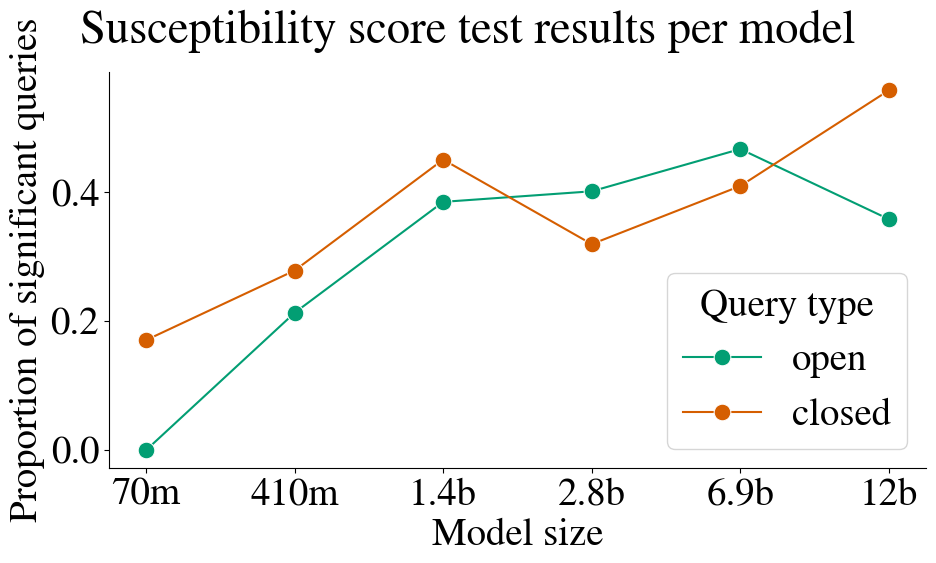

In [19]:
sig_sus_test_results_per_model_df = convert_test_results_dict_to_sig_proportion_df(
    sus_test_results_per_model
)
plot_prop_queries_significant_per_model(
    sig_sus_test_results_per_model_df,
    title="Susceptibility score test results per model",
    save_path=os.path.join(
        analysis_dir, "plot_susscore_vs_pval_proportion_real_fake_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Model size', ylabel='Effect size'>

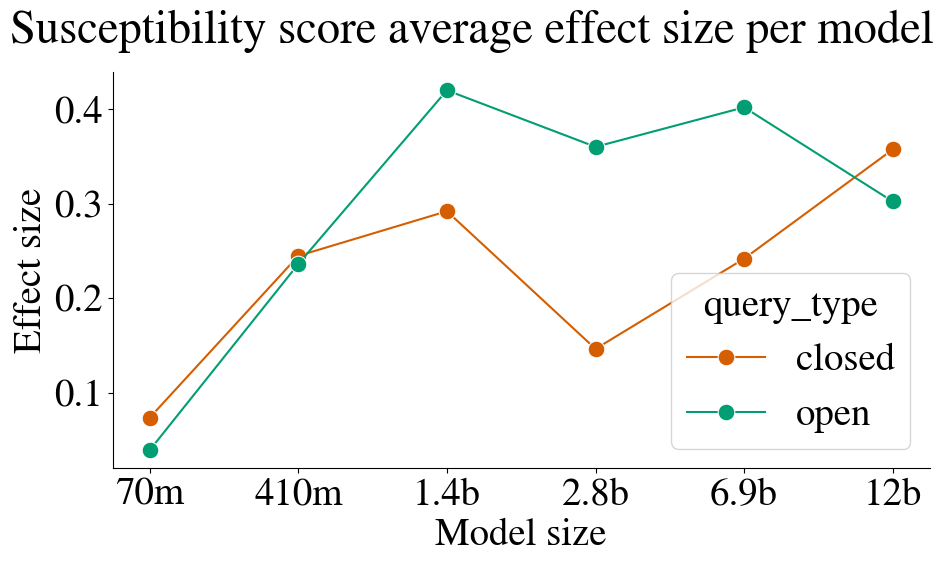

In [20]:
sus_mean_effect_sz_df = build_mean_effect_sz_df(
    sus_open_results_per_model, sus_closed_results_per_model
)
plot_effect_sz_per_model(
    sus_mean_effect_sz_df,
    title="Susceptibility score average effect size per model",
    save_path=os.path.join(
        analysis_dir, "plot_susscore_effect_sz_real_fake_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

## Persuasion scores

### Preprocessing


In [21]:
# Reliability/variance of persuasion scores
tqdm.pandas()
scores_df["contexts"] = scores_df["contexts"].progress_apply(literal_eval)

100%|██████████| 245024/245024 [11:19<00:00, 360.83it/s] 


In [22]:
scores_df["persuasion_scores_kl"] = scores_df["persuasion_scores_kl"].progress_apply(
    literal_eval
)

100%|██████████| 245024/245024 [12:57<00:00, 315.14it/s] 


In [23]:
context_types_per_qid = {
    qid: [
        infer_context_type(c, yago_qec[qid]["context_templates"])[0]
        for c in scores_df[scores_df["QUERY_ID"] == qid]["contexts"].iloc[0]
    ]
    for qid in scores_df["QUERY_ID"].unique()
}
scores_df["context_types"] = scores_df.apply(
    lambda x: context_types_per_qid[x["QUERY_ID"]],
    axis=1,
)

In [24]:
scores_df["context_relevant_vs_irrelevant"] = scores_df.progress_apply(
    lambda x: ["relevant" if x["entity"] in c else "irrelevant" for c in x["contexts"]],
    # context_types_per_qid[x["QUERY_ID"]],
    axis=1,
)

100%|██████████| 245024/245024 [07:35<00:00, 537.43it/s] 


In [25]:
scores_df.columns

Index(['DATASET_NAME', 'RAW_DATA_PATH', 'SEED', 'MODEL_ID', 'LOAD_IN_8BIT',
       'QUERY_ID', 'MAX_CONTEXTS', 'MAX_ENTITIES', 'CAP_PER_TYPE',
       'ABLATE_OUT_RELEVANT_CONTEXTS', 'DEDUPLICATE_ENTITIES',
       'UNIFORM_CONTEXTS', 'ENTITY_SELECTION_FUNC_NAME', 'OVERWRITE',
       'ENTITY_TYPES', 'QUERY_TYPES', 'CONTEXT_TYPES', 'ANSWER_MAP', 'entity',
       'answer', 'query_form', 'entity_type', 'query_type', 'entity_classes',
       'susceptibility_score', 'contexts', 'persuasion_scores_kl',
       'context_types', 'context_relevant_vs_irrelevant'],
      dtype='object')

In [26]:
scores_df.head()

,DATASET_NAME,RAW_DATA_PATH,SEED,MODEL_ID,LOAD_IN_8BIT,QUERY_ID,MAX_CONTEXTS,MAX_ENTITIES,CAP_PER_TYPE,ABLATE_OUT_RELEVANT_CONTEXTS,...,answer,query_form,entity_type,query_type,entity_classes,susceptibility_score,contexts,persuasion_scores_kl,context_types,context_relevant_vs_irrelevant
0,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,anguish,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.078727,"[Definitely, 'A Christmas Carol' is about Isra...","[0.23654992819031548, 0.06147735224624566, 0.0...","[assertive, assertive, base, base, negation, n...","[irrelevant, irrelevant, irrelevant, irrelevan..."
1,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,monster,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.086017,"[Definitely, 'A Christmas Carol' is about Isra...","[0.2072897442686467, 0.11232347902345786, 0.07...","[assertive, assertive, base, base, negation, n...","[irrelevant, irrelevant, irrelevant, irrelevan..."
2,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,prostitution,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.080618,"[Definitely, 'A Christmas Carol' is about Isra...","[0.13167128913944287, 0.07938829101337914, 0.0...","[assertive, assertive, base, base, negation, n...","[irrelevant, irrelevant, irrelevant, irrelevan..."
3,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,Cold War,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.071941,"[Definitely, 'A Christmas Carol' is about Isra...","[0.10235214686042188, 0.05808626597382959, 0.0...","[assertive, assertive, base, base, negation, n...","[irrelevant, irrelevant, irrelevant, irrelevan..."
4,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,time travel,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.072888,"[Definitely, 'A Christmas Carol' is about Isra...","[0.3296797889696658, 0.054896861195177435, 0.0...","[assertive, assertive, base, base, negation, n...","[relevant, relevant, relevant, relevant, relev..."


In [27]:
exploded_df_all = explode_val_df_per_qe(
    scores_df,
    columns=[
        "contexts",
        "persuasion_scores_kl",
        "context_types",
        "context_relevant_vs_irrelevant",
    ],
)

In [28]:
exploded_df_all_per_model = exploded_df_all.groupby("MODEL_ID")
exploded_df_all_per_model = sorted(
    exploded_df_all_per_model, key=lambda x: get_param_size(x[0])
)
print(list(zip(*exploded_df_all_per_model))[0])

('EleutherAI/pythia-70m-deduped', 'EleutherAI/pythia-410m-deduped', 'EleutherAI/pythia-1.4b-deduped', 'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-12b-deduped')


### Assertive vs base

In [29]:
# Process each df in exploded_df_all_per_model to be the mean across all contexts for that entity
mean_pscore_dfs_per_model = []
for model_id, df_m in exploded_df_all_per_model:
    p_score_per_context_type = (
        df_m.groupby(
            ["QUERY_ID", "query_form", "entity", "query_type", "context_types"]
        )
        .agg(mean_p_score=("persuasion_scores_kl", "mean"))
        .reset_index()
    )
    mean_pscore_dfs_per_model.append((model_id, p_score_per_context_type))

MODEL ID: EleutherAI/pythia-70m-deduped


100%|██████████| 123/123 [00:12<00:00,  9.89it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 0,
      "insignificant": 122
    },
    "proportion": {
      "significant (greater)": 0.0,
      "insignificant": 1.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 50,
      "insignificant": 72
    },
    "proportion": {
      "significant (greater)": 0.4098360655737705,
      "insignificant": 0.5901639344262295
    }
  }
}
MODEL ID: EleutherAI/pythia-410m-deduped


100%|██████████| 122/122 [00:12<00:00,  9.99it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 11,
      "insignificant": 110
    },
    "proportion": {
      "significant (greater)": 0.09090909090909091,
      "insignificant": 0.9090909090909091
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 70,
      "insignificant": 51
    },
    "proportion": {
      "significant (greater)": 0.5785123966942148,
      "insignificant": 0.4214876033057851
    }
  }
}
MODEL ID: EleutherAI/pythia-1.4b-deduped


100%|██████████| 122/122 [00:12<00:00,  9.97it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 31,
      "insignificant": 90
    },
    "proportion": {
      "significant (greater)": 0.256198347107438,
      "insignificant": 0.743801652892562
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 103,
      "insignificant": 18
    },
    "proportion": {
      "significant (greater)": 0.8512396694214877,
      "insignificant": 0.1487603305785124
    }
  }
}
MODEL ID: EleutherAI/pythia-2.8b-deduped


100%|██████████| 122/122 [00:12<00:00,  9.53it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 15,
      "insignificant": 106
    },
    "proportion": {
      "significant (greater)": 0.12396694214876033,
      "insignificant": 0.8760330578512396
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 114,
      "insignificant": 7
    },
    "proportion": {
      "significant (greater)": 0.9421487603305785,
      "insignificant": 0.05785123966942149
    }
  }
}
MODEL ID: EleutherAI/pythia-6.9b-deduped


100%|██████████| 122/122 [00:13<00:00,  9.21it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 1,
      "insignificant": 120
    },
    "proportion": {
      "significant (greater)": 0.008264462809917356,
      "insignificant": 0.9917355371900827
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 112,
      "insignificant": 9
    },
    "proportion": {
      "significant (greater)": 0.9256198347107438,
      "insignificant": 0.0743801652892562
    }
  }
}
MODEL ID: EleutherAI/pythia-12b-deduped


100%|██████████| 120/120 [00:12<00:00,  9.77it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 0,
      "insignificant": 119
    },
    "proportion": {
      "significant (greater)": 0.0,
      "insignificant": 1.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 97,
      "insignificant": 22
    },
    "proportion": {
      "significant (greater)": 0.8151260504201681,
      "insignificant": 0.18487394957983194
    }
  }
}


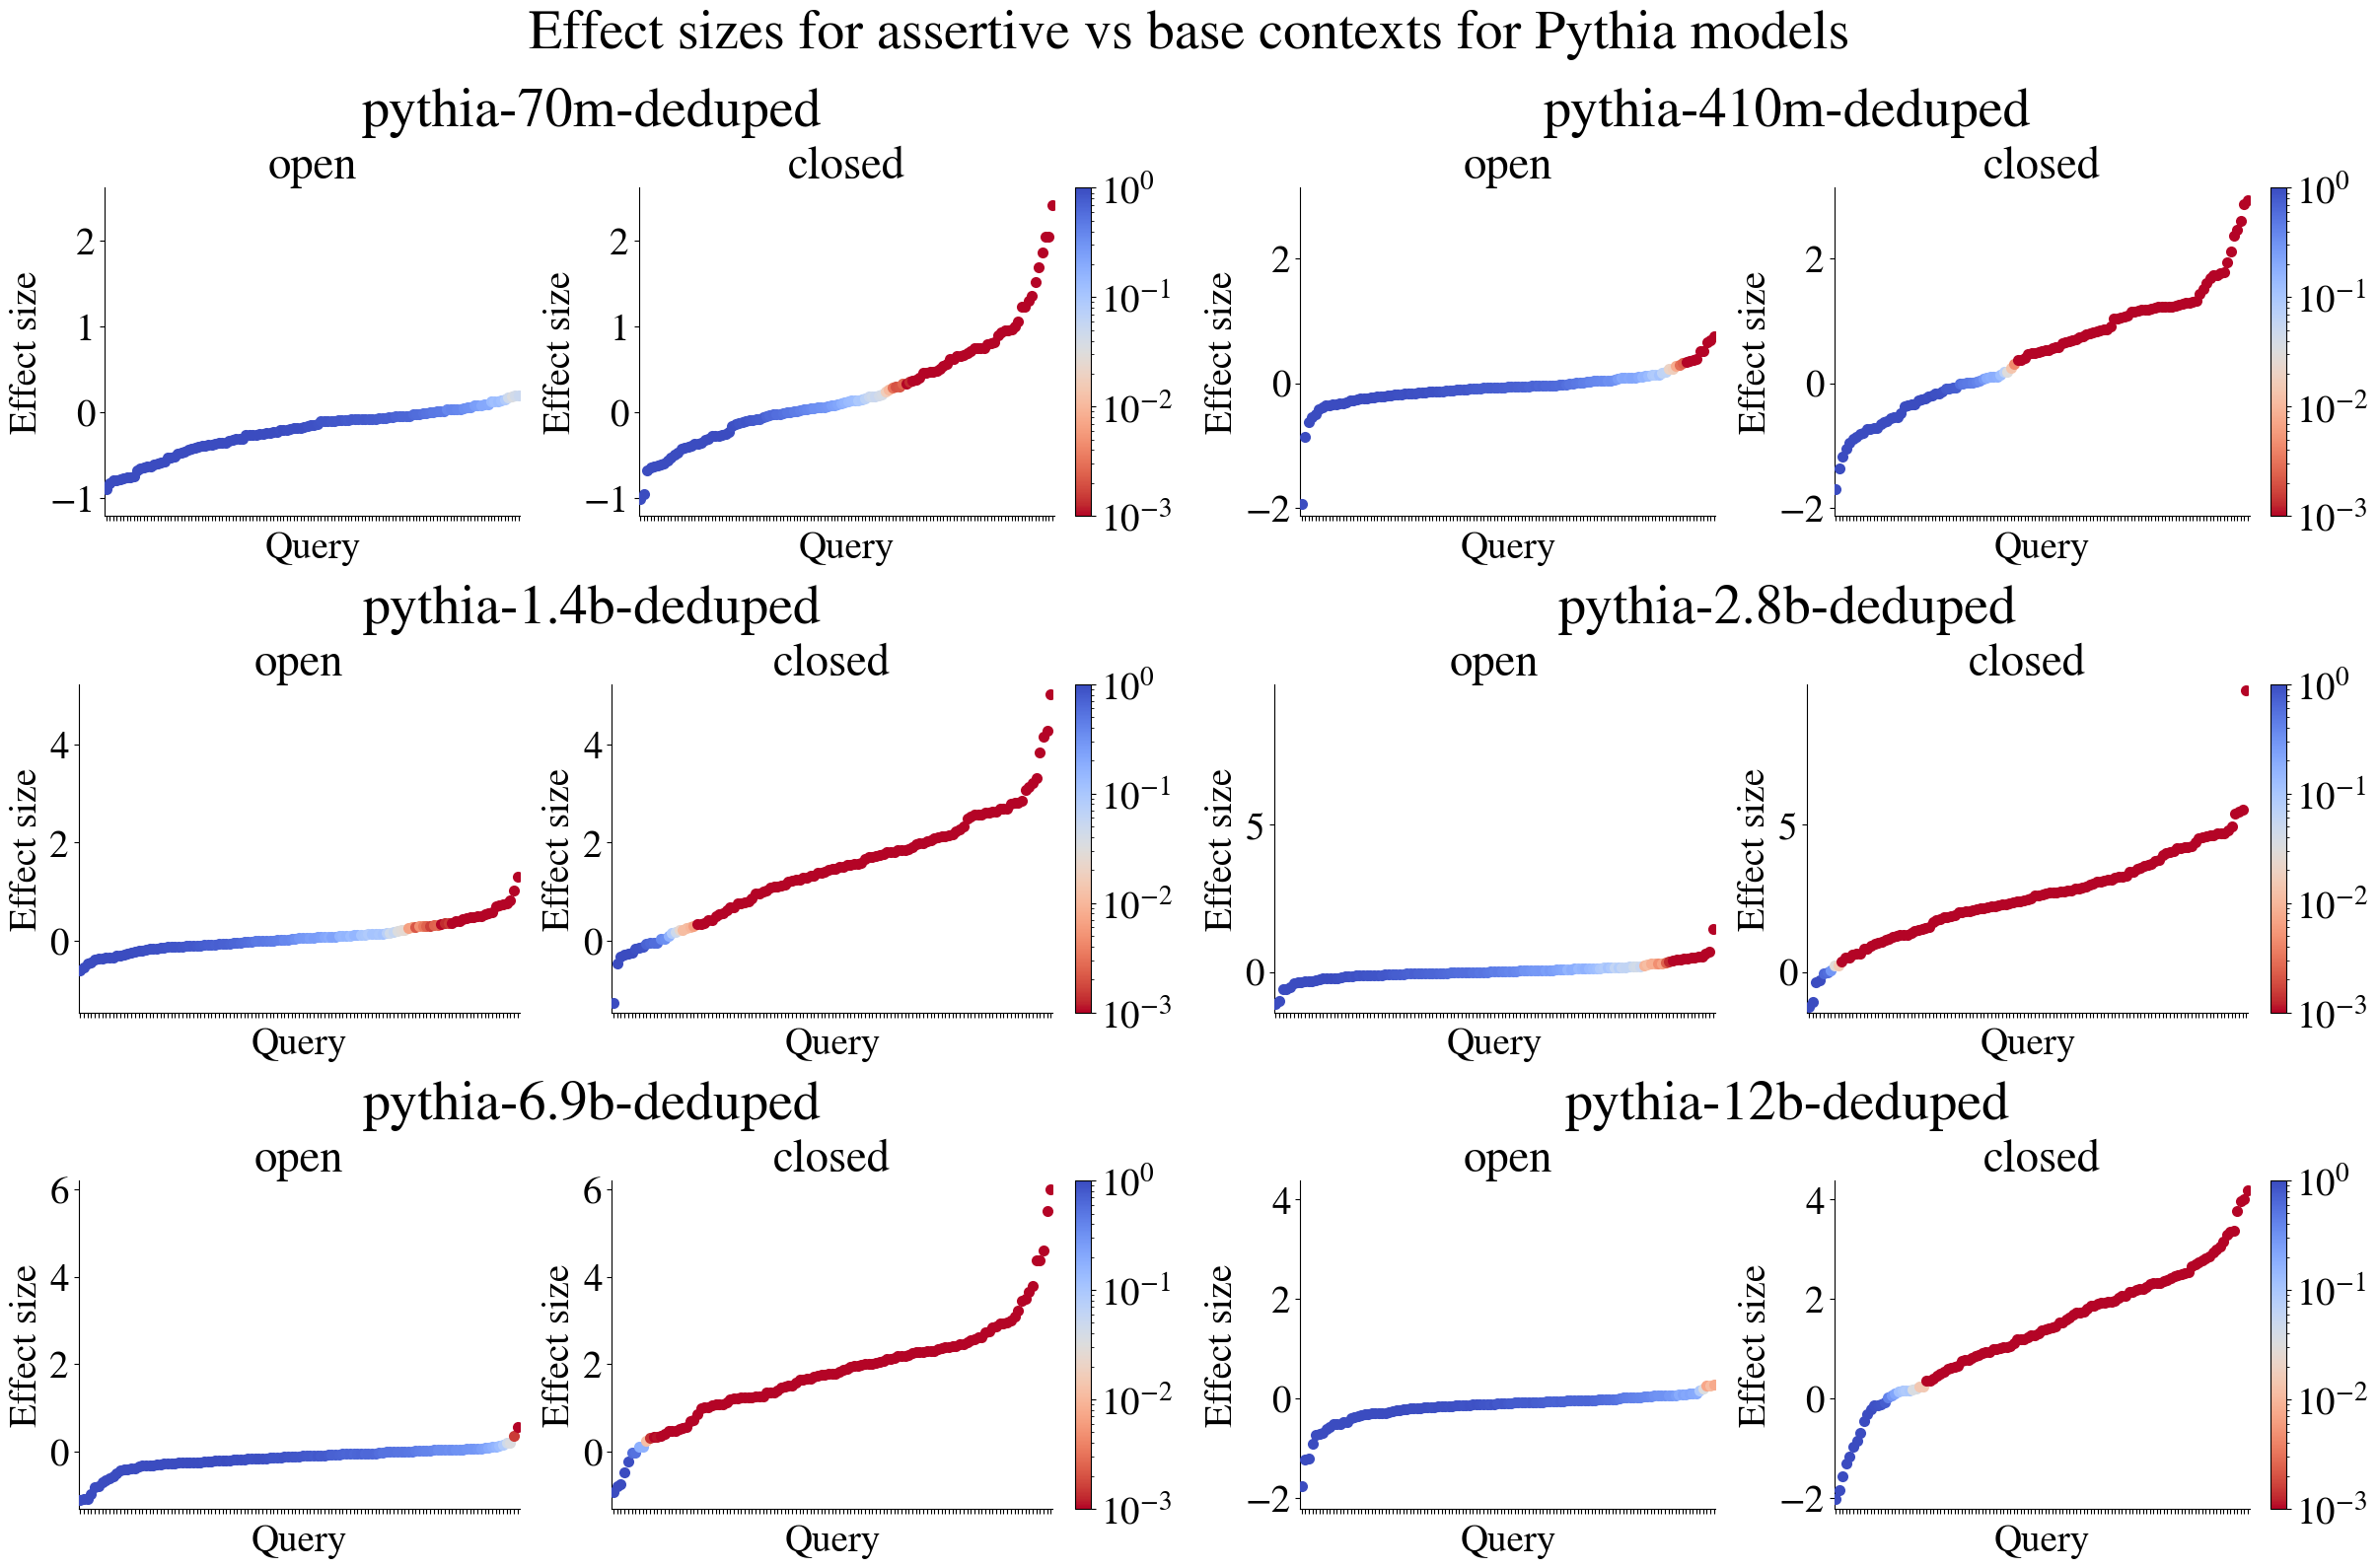

In [30]:
(
    assertive_open_results_per_model,
    assertive_closed_results_per_model,
    assertive_test_results_per_model,
) = get_test_results_and_plot_per_model(
    mean_pscore_dfs_per_model,
    group1="assertive",
    group2="base",
    score_col="mean_p_score",
    type_col="context_types",
    alternative="greater",
    permutations=10000,
    title="Effect sizes for assertive vs base contexts for Pythia models",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_base_vs_assertive_all_models.pdf"
    ),
    cm=cm,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


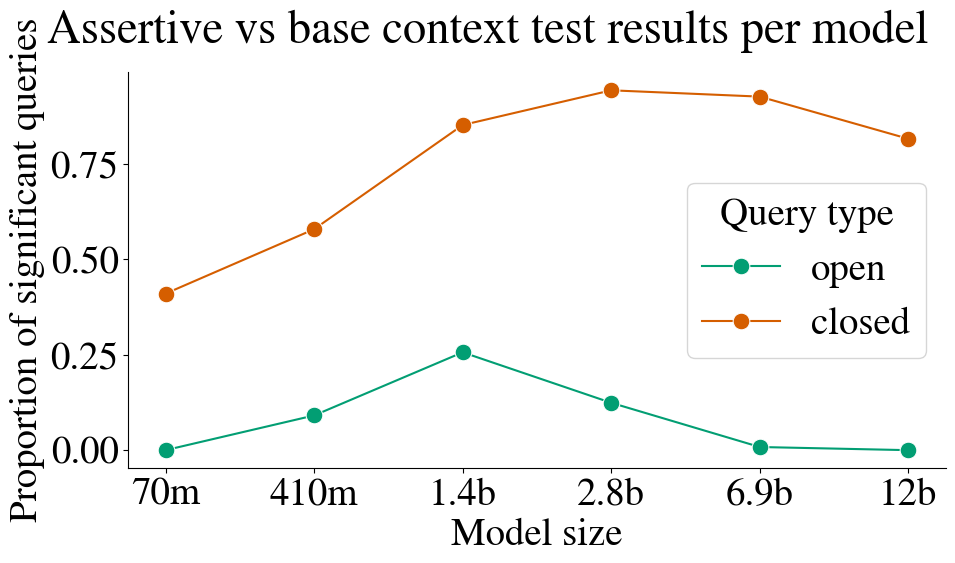

In [31]:
sig_assertive_test_results_per_model_df = (
    convert_test_results_dict_to_sig_proportion_df(assertive_test_results_per_model)
)
plot_prop_queries_significant_per_model(
    sig_assertive_test_results_per_model_df,
    title="Assertive vs base context test results per model",
    save_path=os.path.join(
        analysis_dir, "plot_assertive_vs_base_pval_proportion_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Model size', ylabel='Effect size'>

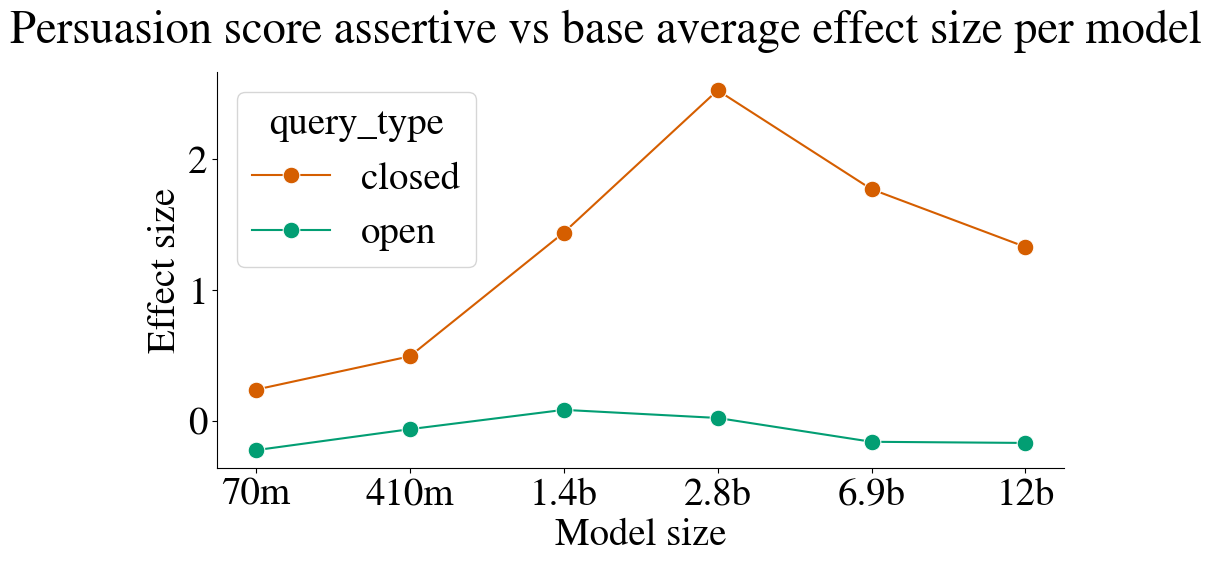

In [32]:
assertive_mean_effect_sz_df = build_mean_effect_sz_df(
    assertive_open_results_per_model, assertive_closed_results_per_model
)
plot_effect_sz_per_model(
    assertive_mean_effect_sz_df,
    title="Persuasion score assertive vs base average effect size per model",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_effect_sz_assertive_base_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

### Negation vs base

MODEL ID: EleutherAI/pythia-70m-deduped


100%|██████████| 123/123 [00:12<00:00,  9.73it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 106,
      "insignificant": 16
    },
    "proportion": {
      "significant (two-sided)": 0.8688524590163934,
      "insignificant": 0.13114754098360656
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 121,
      "insignificant": 1
    },
    "proportion": {
      "significant (two-sided)": 0.9918032786885246,
      "insignificant": 0.00819672131147541
    }
  }
}
MODEL ID: EleutherAI/pythia-410m-deduped


100%|██████████| 122/122 [00:12<00:00,  9.46it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 67,
      "insignificant": 54
    },
    "proportion": {
      "significant (two-sided)": 0.5537190082644629,
      "insignificant": 0.4462809917355372
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 102,
      "insignificant": 19
    },
    "proportion": {
      "significant (two-sided)": 0.8429752066115702,
      "insignificant": 0.15702479338842976
    }
  }
}
MODEL ID: EleutherAI/pythia-1.4b-deduped


100%|██████████| 122/122 [00:12<00:00,  9.99it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 86,
      "insignificant": 35
    },
    "proportion": {
      "significant (two-sided)": 0.7107438016528925,
      "insignificant": 0.2892561983471074
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 102,
      "insignificant": 19
    },
    "proportion": {
      "significant (two-sided)": 0.8429752066115702,
      "insignificant": 0.15702479338842976
    }
  }
}
MODEL ID: EleutherAI/pythia-2.8b-deduped


100%|██████████| 122/122 [00:12<00:00, 10.00it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 85,
      "insignificant": 36
    },
    "proportion": {
      "significant (two-sided)": 0.7024793388429752,
      "insignificant": 0.2975206611570248
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 117,
      "insignificant": 4
    },
    "proportion": {
      "significant (two-sided)": 0.9669421487603306,
      "insignificant": 0.03305785123966942
    }
  }
}
MODEL ID: EleutherAI/pythia-6.9b-deduped


100%|██████████| 122/122 [00:11<00:00, 10.35it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 88,
      "insignificant": 33
    },
    "proportion": {
      "significant (two-sided)": 0.7272727272727273,
      "insignificant": 0.2727272727272727
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 105,
      "insignificant": 16
    },
    "proportion": {
      "significant (two-sided)": 0.8677685950413223,
      "insignificant": 0.1322314049586777
    }
  }
}
MODEL ID: EleutherAI/pythia-12b-deduped


100%|██████████| 120/120 [00:11<00:00, 10.41it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 71,
      "insignificant": 48
    },
    "proportion": {
      "significant (two-sided)": 0.5966386554621849,
      "insignificant": 0.40336134453781514
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 99,
      "insignificant": 20
    },
    "proportion": {
      "significant (two-sided)": 0.8319327731092437,
      "insignificant": 0.16806722689075632
    }
  }
}


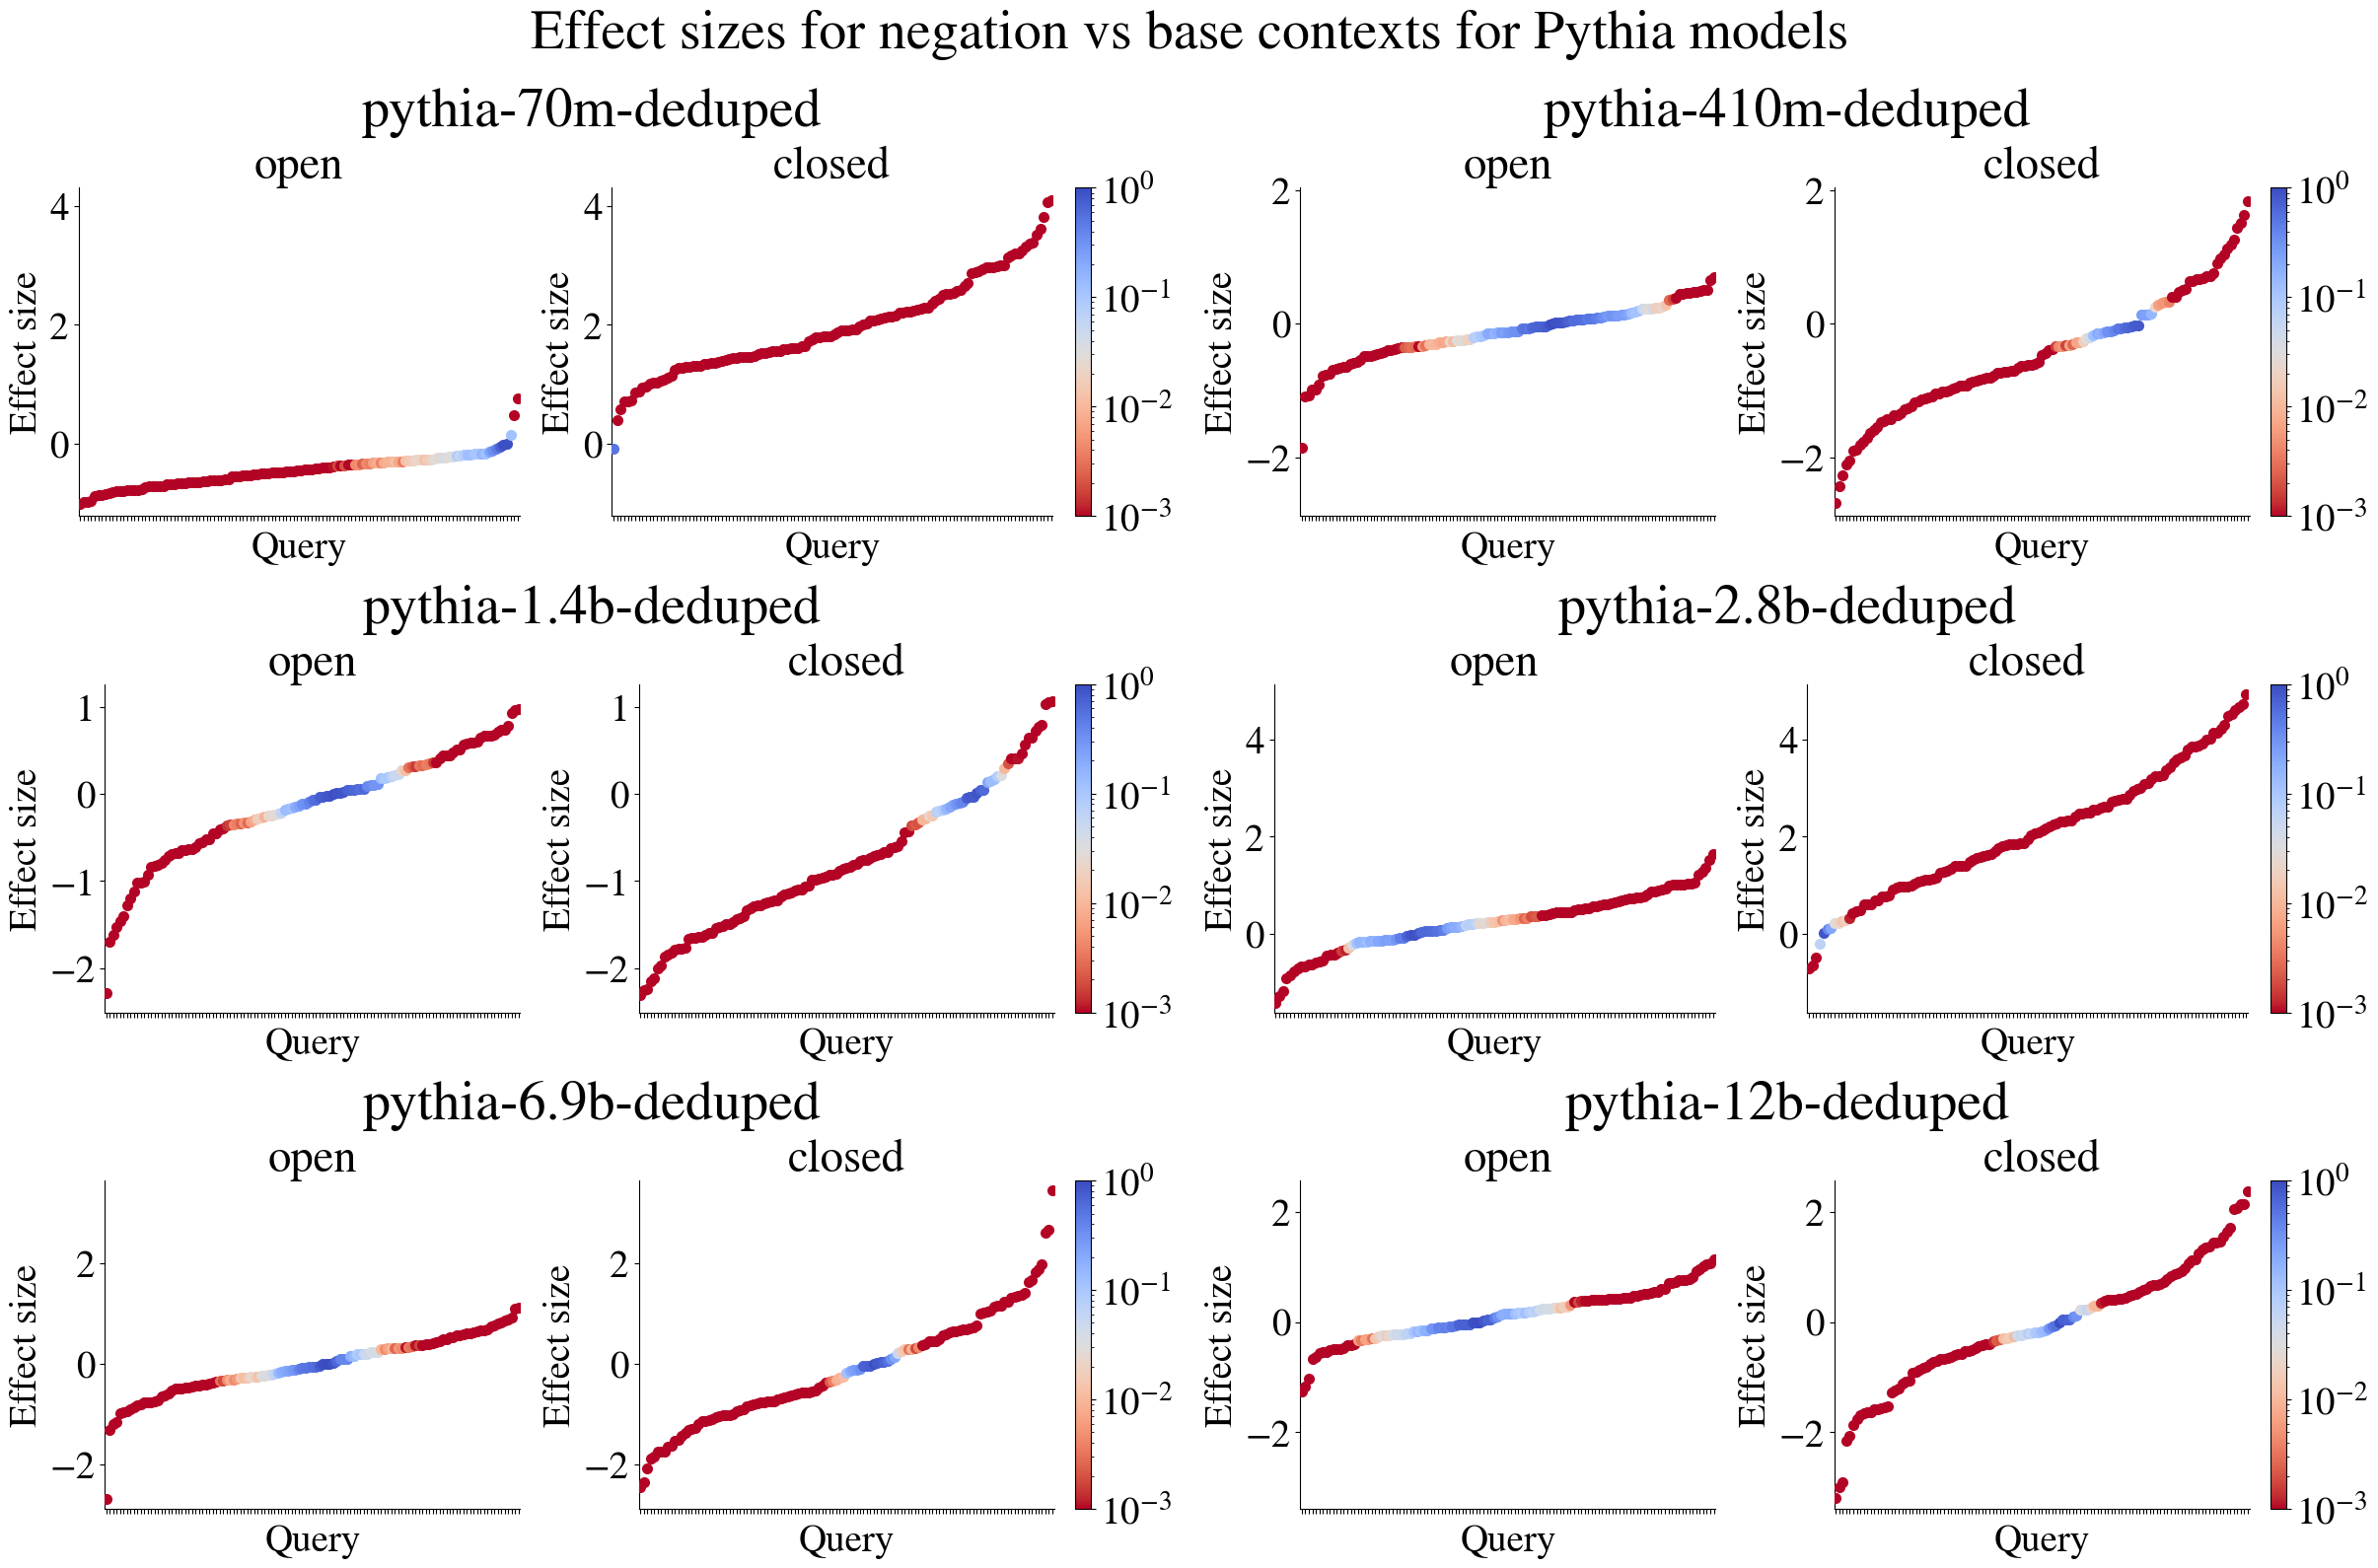

In [33]:
(
    negation_open_results_per_model,
    negation_closed_results_per_model,
    negation_test_results_per_model,
) = get_test_results_and_plot_per_model(
    mean_pscore_dfs_per_model,
    group1="negation",
    group2="base",
    score_col="mean_p_score",
    type_col="context_types",
    alternative="two-sided",
    permutations=10000,
    title="Effect sizes for negation vs base contexts for Pythia models",
    save_path=os.path.join(analysis_dir, "plot_pscore_negation_vs_base_all_models.pdf"),
    cm=cm,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib

<Axes: xlabel='Model size', ylabel='Effect size'>

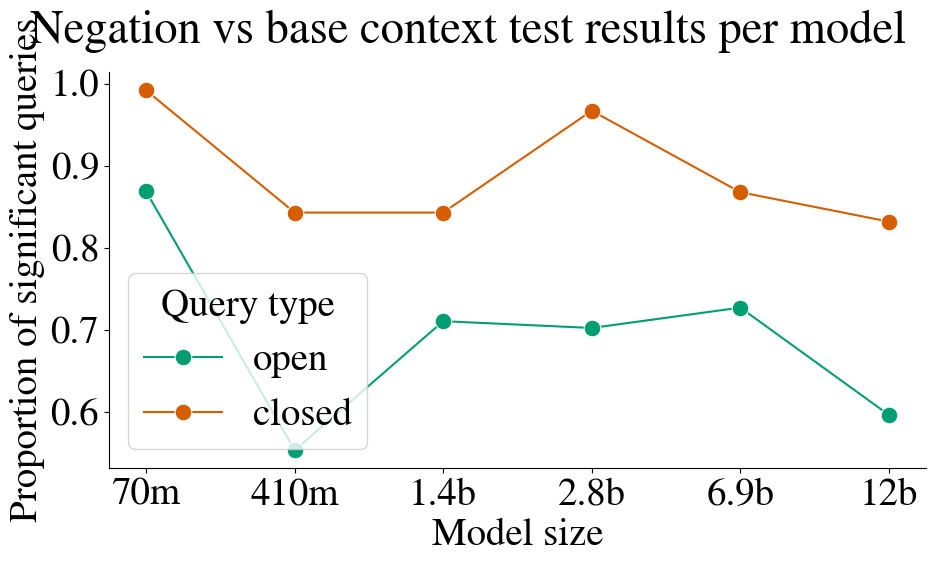

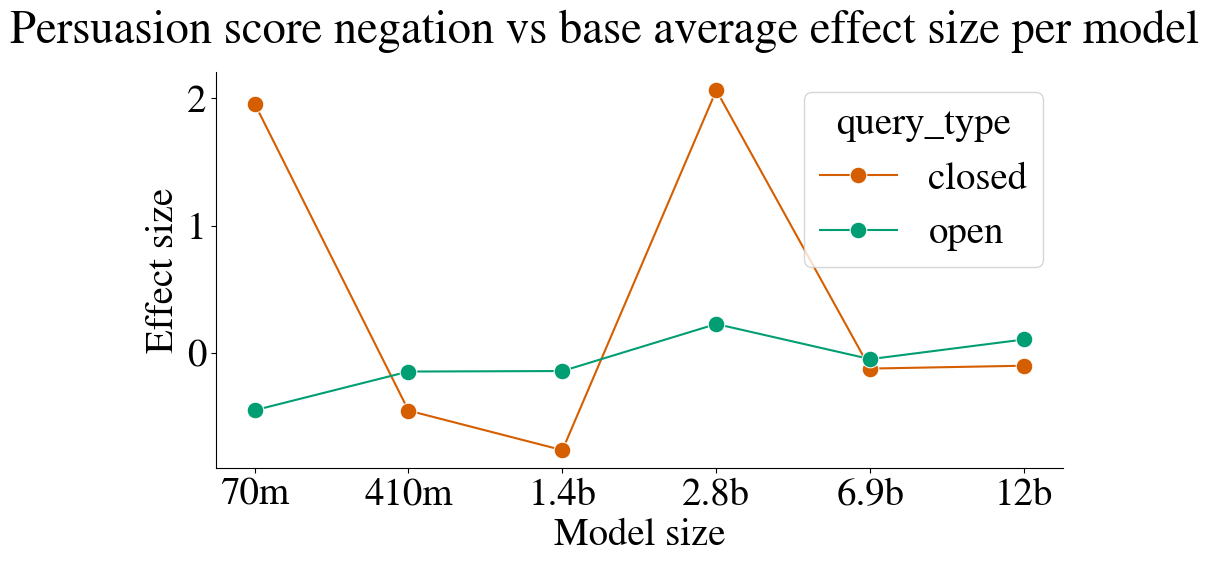

In [34]:
negation_test_results_per_model_df = convert_test_results_dict_to_sig_proportion_df(
    negation_test_results_per_model
)
plot_prop_queries_significant_per_model(
    negation_test_results_per_model_df,
    title="Negation vs base context test results per model",
    save_path=os.path.join(
        analysis_dir, "plot_negation_vs_base_pval_proportion_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

negation_mean_effect_sz_df = build_mean_effect_sz_df(
    negation_open_results_per_model, negation_closed_results_per_model
)
plot_effect_sz_per_model(
    negation_mean_effect_sz_df,
    title="Persuasion score negation vs base average effect size per model",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_effect_sz_negation_base_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

### Relevant vs irrelevant

In [35]:
# Process each df in exploded_df_all_per_model to be the mean across all contexts for that entity
mean_pscore_relevant_dfs_per_model = []
for model_id, df_m in exploded_df_all_per_model:
    p_score_per_context_type = (
        df_m.groupby(
            [
                "QUERY_ID",
                "query_form",
                "entity",
                "query_type",
                "context_relevant_vs_irrelevant",
            ]
        )
        .agg(mean_p_score=("persuasion_scores_kl", "mean"))
        .reset_index()
    )
    mean_pscore_relevant_dfs_per_model.append((model_id, p_score_per_context_type))

MODEL ID: EleutherAI/pythia-70m-deduped


100%|██████████| 123/123 [00:12<00:00,  9.74it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 123,
      "insignificant": 0
    },
    "proportion": {
      "significant (greater)": 1.0,
      "insignificant": 0.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 123,
      "insignificant": 0
    },
    "proportion": {
      "significant (greater)": 1.0,
      "insignificant": 0.0
    }
  }
}
MODEL ID: EleutherAI/pythia-410m-deduped


100%|██████████| 122/122 [00:13<00:00,  8.89it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 122,
      "insignificant": 0
    },
    "proportion": {
      "significant (greater)": 1.0,
      "insignificant": 0.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 121,
      "insignificant": 1
    },
    "proportion": {
      "significant (greater)": 0.9918032786885246,
      "insignificant": 0.00819672131147541
    }
  }
}
MODEL ID: EleutherAI/pythia-1.4b-deduped


100%|██████████| 122/122 [00:12<00:00,  9.43it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 121,
      "insignificant": 1
    },
    "proportion": {
      "significant (greater)": 0.9918032786885246,
      "insignificant": 0.00819672131147541
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 115,
      "insignificant": 7
    },
    "proportion": {
      "significant (greater)": 0.9426229508196722,
      "insignificant": 0.05737704918032787
    }
  }
}
MODEL ID: EleutherAI/pythia-2.8b-deduped


100%|██████████| 122/122 [00:14<00:00,  8.14it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 116,
      "insignificant": 6
    },
    "proportion": {
      "significant (greater)": 0.9508196721311475,
      "insignificant": 0.04918032786885246
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 101,
      "insignificant": 21
    },
    "proportion": {
      "significant (greater)": 0.8278688524590164,
      "insignificant": 0.1721311475409836
    }
  }
}
MODEL ID: EleutherAI/pythia-6.9b-deduped


100%|██████████| 122/122 [00:16<00:00,  7.56it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 119,
      "insignificant": 3
    },
    "proportion": {
      "significant (greater)": 0.9754098360655737,
      "insignificant": 0.02459016393442623
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 122,
      "insignificant": 0
    },
    "proportion": {
      "significant (greater)": 1.0,
      "insignificant": 0.0
    }
  }
}
MODEL ID: EleutherAI/pythia-12b-deduped


100%|██████████| 120/120 [00:12<00:00,  9.56it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 117,
      "insignificant": 3
    },
    "proportion": {
      "significant (greater)": 0.975,
      "insignificant": 0.025
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 118,
      "insignificant": 2
    },
    "proportion": {
      "significant (greater)": 0.9833333333333333,
      "insignificant": 0.016666666666666666
    }
  }
}


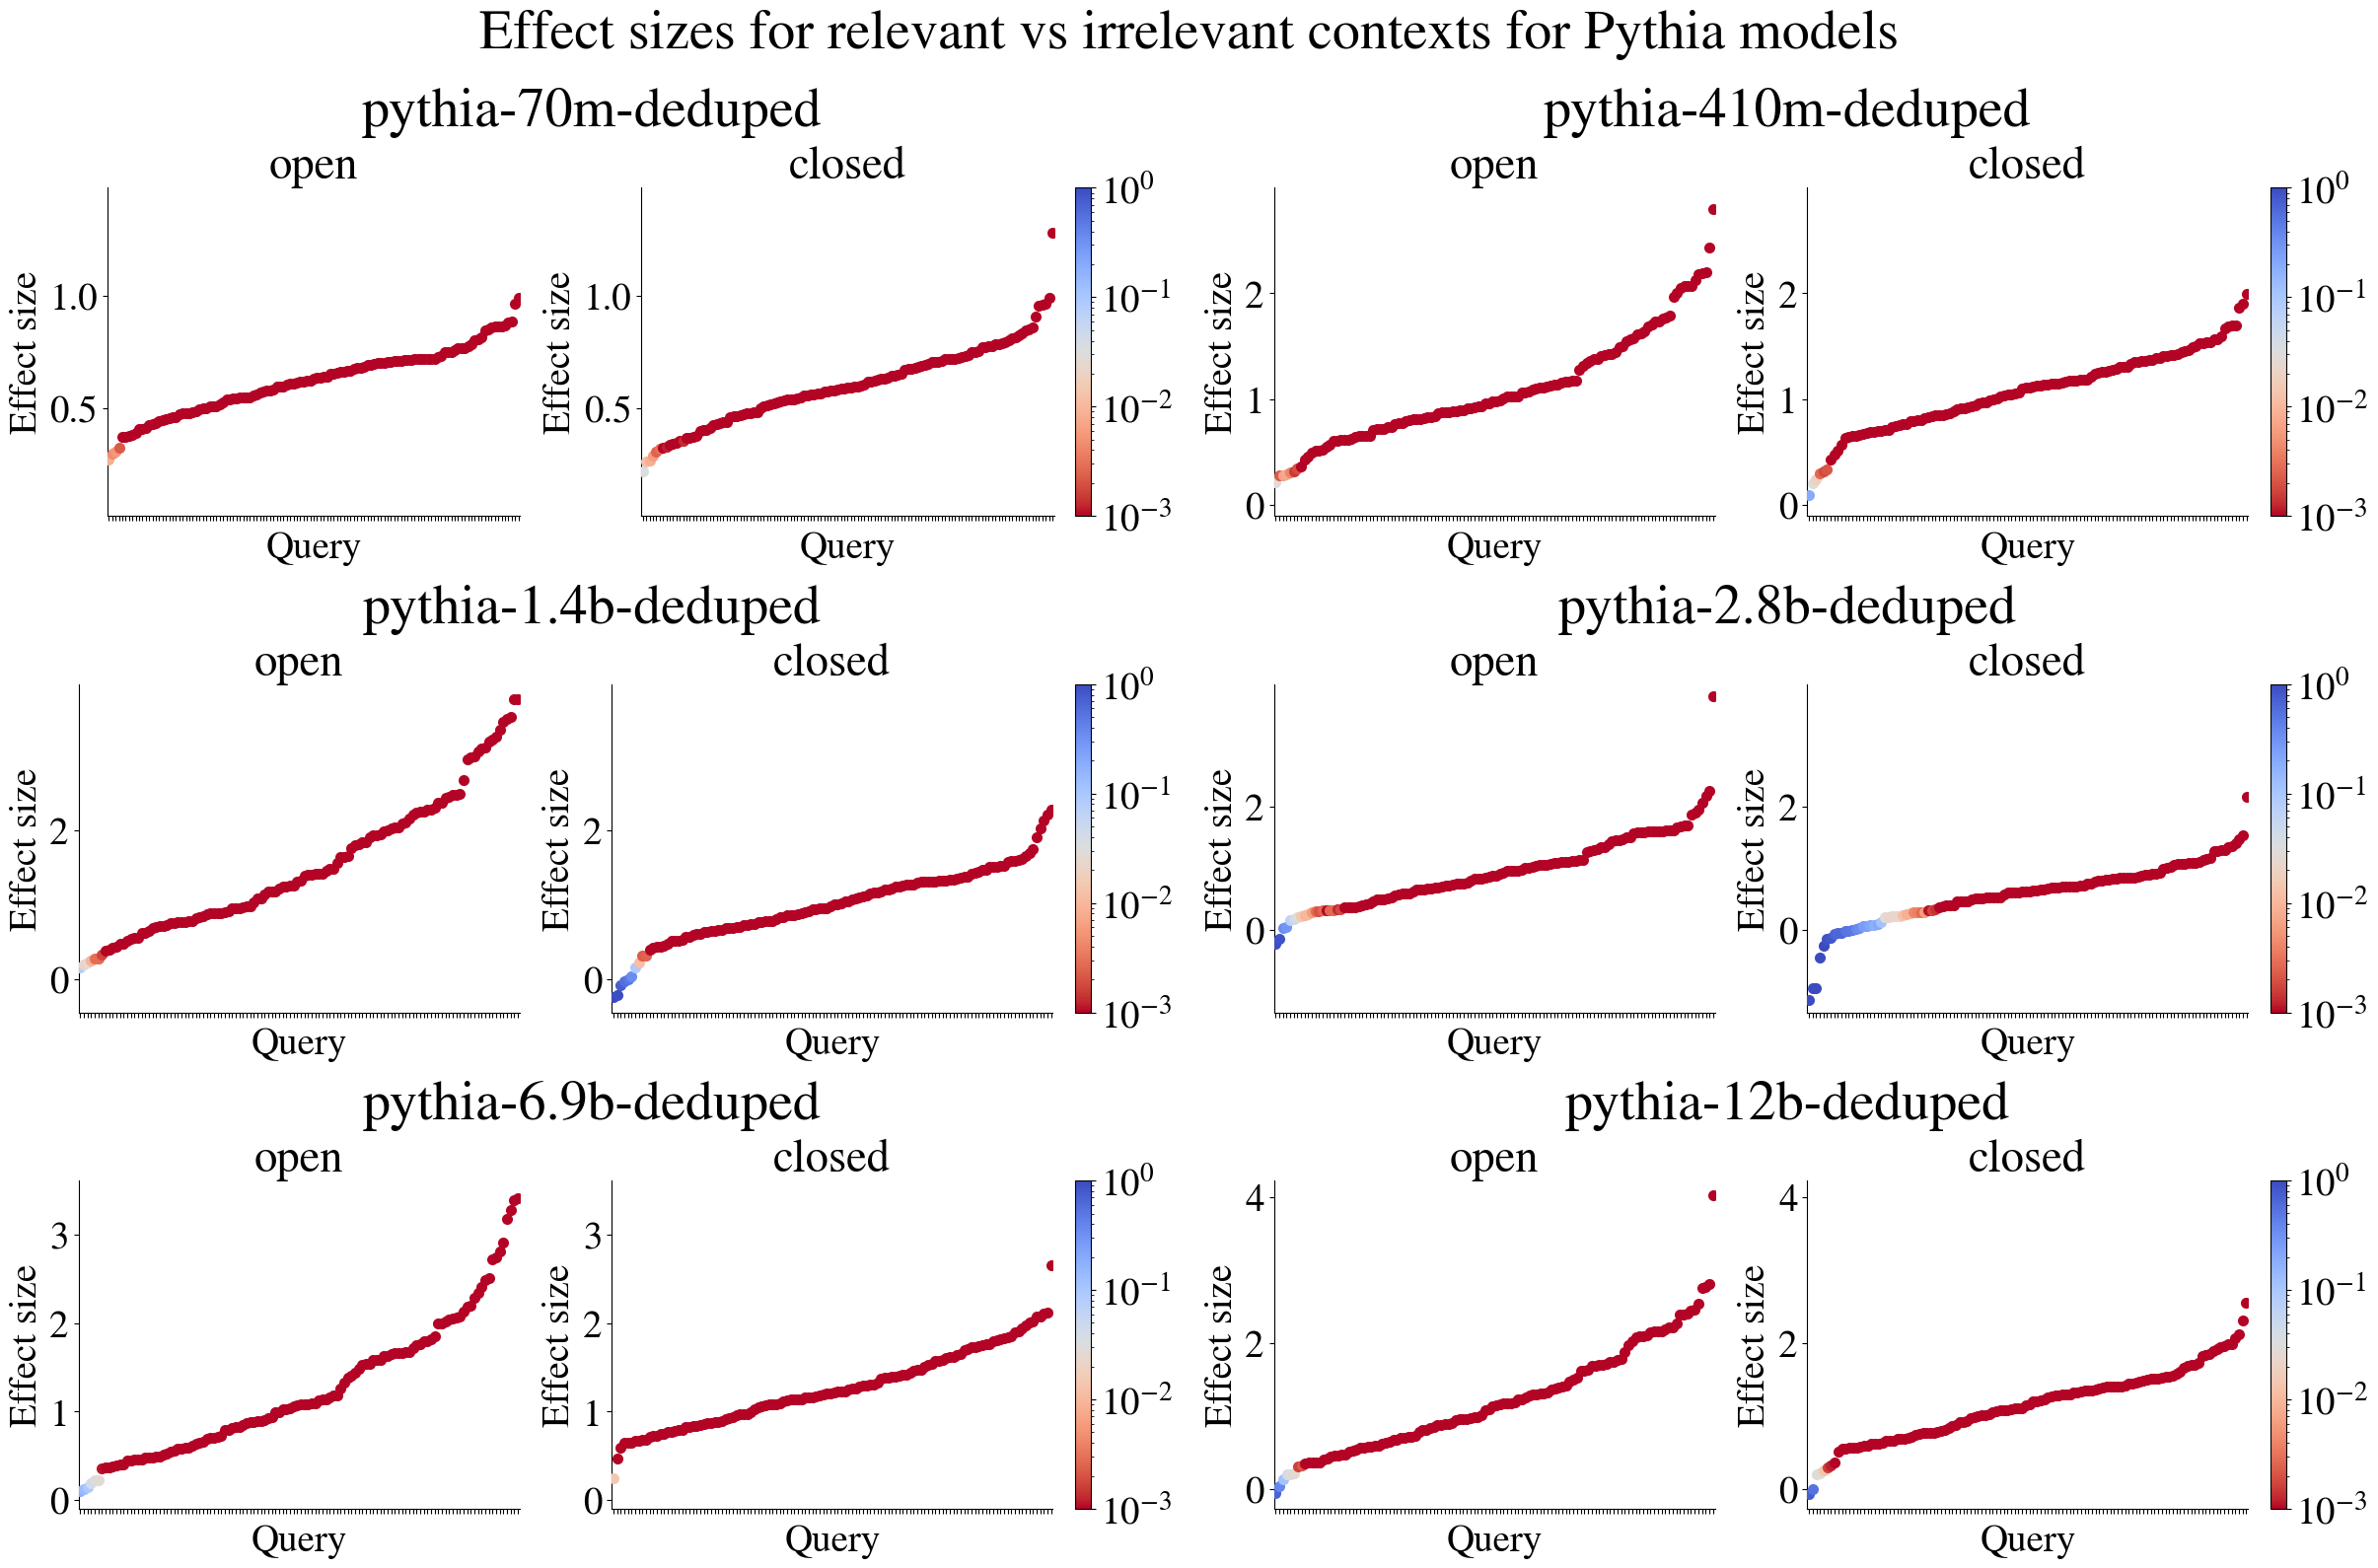

In [36]:
(
    rel_vs_irrel_open_results_per_model,
    rel_vs_irrel_closed_results_per_model,
    rel_vs_irrel_test_results_per_model,
) = get_test_results_and_plot_per_model(
    mean_pscore_relevant_dfs_per_model,
    group1="relevant",
    group2="irrelevant",
    score_col="mean_p_score",
    type_col="context_relevant_vs_irrelevant",
    alternative="greater",
    permutations=10000,
    title="Effect sizes for relevant vs irrelevant contexts for Pythia models",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_relevant_vs_irrelevant_all_models.pdf"
    ),
    cm=cm,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib

<Axes: xlabel='Model size', ylabel='Effect size'>

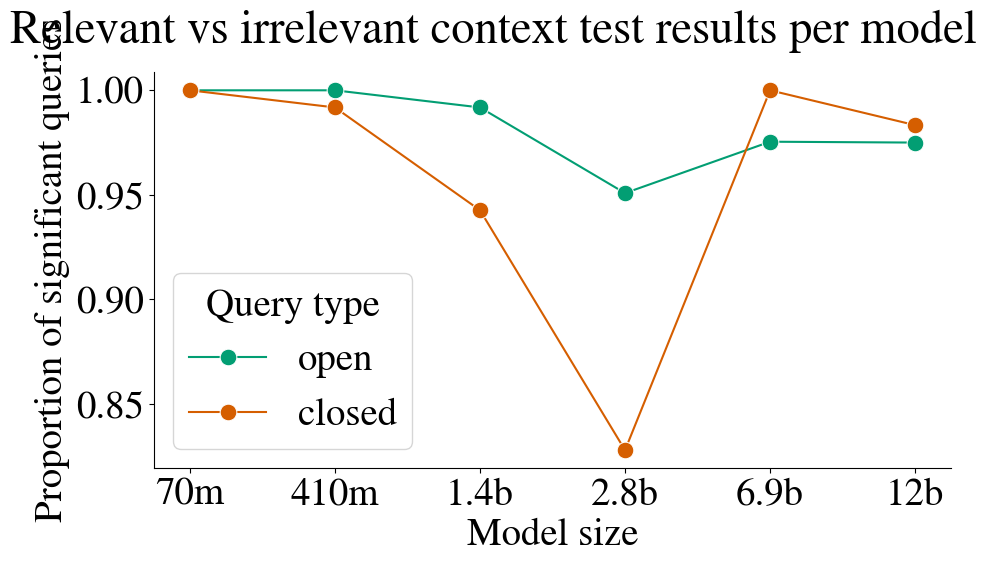

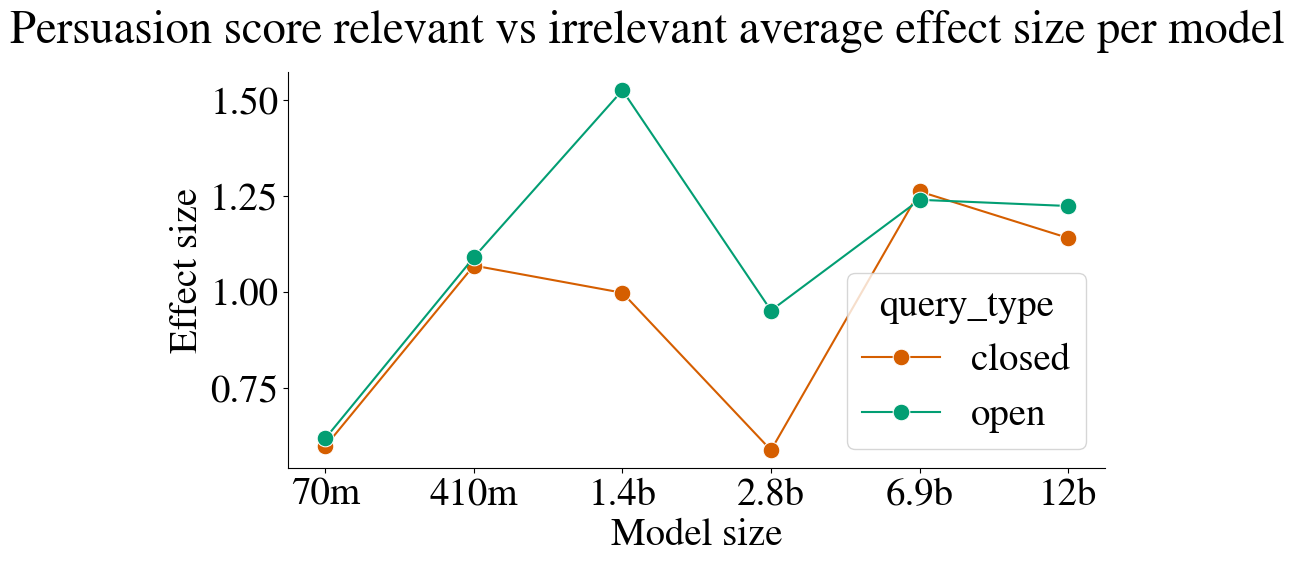

In [37]:
rel_vs_irrel_test_results_per_model_df = convert_test_results_dict_to_sig_proportion_df(
    rel_vs_irrel_test_results_per_model
)
plot_prop_queries_significant_per_model(
    rel_vs_irrel_test_results_per_model_df,
    title="Relevant vs irrelevant context test results per model",
    save_path=os.path.join(
        analysis_dir, "plot_relevant_vs_irrelevant_pval_proportion_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

rel_vs_irrel_mean_effect_sz_df = build_mean_effect_sz_df(
    rel_vs_irrel_open_results_per_model, rel_vs_irrel_closed_results_per_model
)
plot_effect_sz_per_model(
    rel_vs_irrel_mean_effect_sz_df,
    title="Persuasion score relevant vs irrelevant average effect size per model",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_effect_sz_relevant_irrelevant_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

### Aggregated plots

In [38]:
sig_sus_test_results_per_model_df["Comparison"] = "Familiar vs unfamiliar entities"
sig_assertive_test_results_per_model_df["Comparison"] = "Assertive vs base contexts"
negation_test_results_per_model_df["Comparison"] = "Negation vs base contexts"
rel_vs_irrel_test_results_per_model_df["Comparison"] = "Relevant vs irrelevant contexts"
all_tests_combined_df = pd.concat(
    [
        sig_sus_test_results_per_model_df,
        sig_assertive_test_results_per_model_df,
        negation_test_results_per_model_df,
        rel_vs_irrel_test_results_per_model_df,
    ]
)
all_tests_combined_df

,model_name,Model size,Model size count,Query type,metric_type,significance,value,Comparison
2,EleutherAI/pythia-70m-deduped,70m,7.000000e+07,open,proportion,significant (greater),0.000000,Familiar vs unfamiliar entities
6,EleutherAI/pythia-70m-deduped,70m,7.000000e+07,closed,proportion,significant (greater),0.170732,Familiar vs unfamiliar entities
14,EleutherAI/pythia-410m-deduped,410m,4.100000e+08,closed,proportion,significant (greater),0.278689,Familiar vs unfamiliar entities
10,EleutherAI/pythia-410m-deduped,410m,4.100000e+08,open,proportion,significant (greater),0.213115,Familiar vs unfamiliar entities
22,EleutherAI/pythia-1.4b-deduped,1.4b,1.400000e+09,closed,proportion,significant (greater),0.450820,Familiar vs unfamiliar entities
18,EleutherAI/pythia-1.4b-deduped,1.4b,1.400000e+09,open,proportion,significant (greater),0.385246,Familiar vs unfamiliar entities
26,EleutherAI/pythia-2.8b-deduped,2.8b,2.800000e+09,open,proportion,significant (greater),0.401639,Familiar vs unfamiliar entities
30,EleutherAI/pythia-2.8b-deduped,2.8b,2.800000e+09,closed,proportion,significant (greater),0.319672,Familiar vs unfamiliar entities
38,EleutherAI/pythia-6.9b-deduped,6.9b,6.900000e+09,closed,proportion,significant (greater),0.409836,Familiar vs unfamiliar entities
34,EleutherAI/pythia-6.9b-deduped,6.9b,6.900000e+09,open,proportion,significant (greater),0.467213,Familiar vs unfamiliar entities


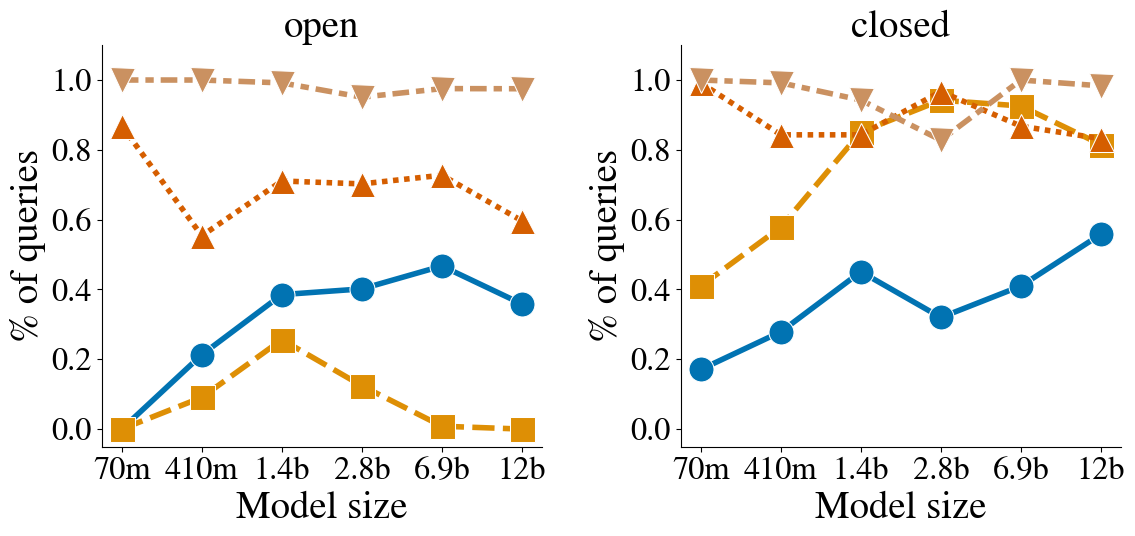

In [39]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for i, qt in enumerate(
    sorted(all_tests_combined_df["Query type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.lineplot(
        data=all_tests_combined_df[all_tests_combined_df["Query type"] == qt],
        x="Model size",
        y="value",
        hue="Comparison",
        style="Comparison",
        markers=["o", "s", "^", "v"],
        markersize=18,
        linewidth=4,
        ax=ax,
        legend=None,
        # legend=None if i == 0 else True,
        palette=comparison_colormap,
    )
    ax.set_title(qt, size="medium")
    ax.set_xlabel("Model size", size="medium")
    ax.set_ylabel("% of queries", size="medium")
    ax.set_ylim(-0.05, 1.1)
    ax.tick_params(axis="both", which="major", labelsize="small")


# fig.suptitle(
#     "% of queries with significant results",
#     # "% of queries with significant results for different comparisons and models",
#     y=0.92,
# )
plt.tight_layout()

plot_name = f"plot_comparisons_prop_sig_models_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

This plot indicates the proportion of queries for which (bronze down triangles) relevant contexts are significantly more persuasive than irrelevant contexts, (blue circles) unfamiliar entities are significantly more susceptible than familiar entities, (yellow squares) assertive contexts are significantly more persuasive than base contexts, and (orange triangles) negation contexts are significantly more persuasive than base contexts.

In [40]:
sus_mean_effect_sz_df["Comparison"] = "Familiar vs unfamiliar entities"
assertive_mean_effect_sz_df["Comparison"] = "Assertive vs base contexts"
negation_mean_effect_sz_df["Comparison"] = "Negation vs base contexts"
rel_vs_irrel_mean_effect_sz_df["Comparison"] = "Relevant vs irrelevant contexts"
all_effect_szs_combined_df = pd.concat(
    [
        sus_mean_effect_sz_df,
        assertive_mean_effect_sz_df,
        negation_mean_effect_sz_df,
        rel_vs_irrel_mean_effect_sz_df,
    ]
)
all_effect_szs_combined_df

,model_name,Model size,query_type,mean_effect_sz,Model size count,Comparison
10,EleutherAI/pythia-70m-deduped,70m,closed,0.073828,7.000000e+07,Familiar vs unfamiliar entities
11,EleutherAI/pythia-70m-deduped,70m,open,0.039495,7.000000e+07,Familiar vs unfamiliar entities
6,EleutherAI/pythia-410m-deduped,410m,closed,0.244951,4.100000e+08,Familiar vs unfamiliar entities
7,EleutherAI/pythia-410m-deduped,410m,open,0.236352,4.100000e+08,Familiar vs unfamiliar entities
0,EleutherAI/pythia-1.4b-deduped,1.4b,closed,0.292160,1.400000e+09,Familiar vs unfamiliar entities
1,EleutherAI/pythia-1.4b-deduped,1.4b,open,0.420033,1.400000e+09,Familiar vs unfamiliar entities
4,EleutherAI/pythia-2.8b-deduped,2.8b,closed,0.146606,2.800000e+09,Familiar vs unfamiliar entities
5,EleutherAI/pythia-2.8b-deduped,2.8b,open,0.360225,2.800000e+09,Familiar vs unfamiliar entities
8,EleutherAI/pythia-6.9b-deduped,6.9b,closed,0.242004,6.900000e+09,Familiar vs unfamiliar entities
9,EleutherAI/pythia-6.9b-deduped,6.9b,open,0.402046,6.900000e+09,Familiar vs unfamiliar entities


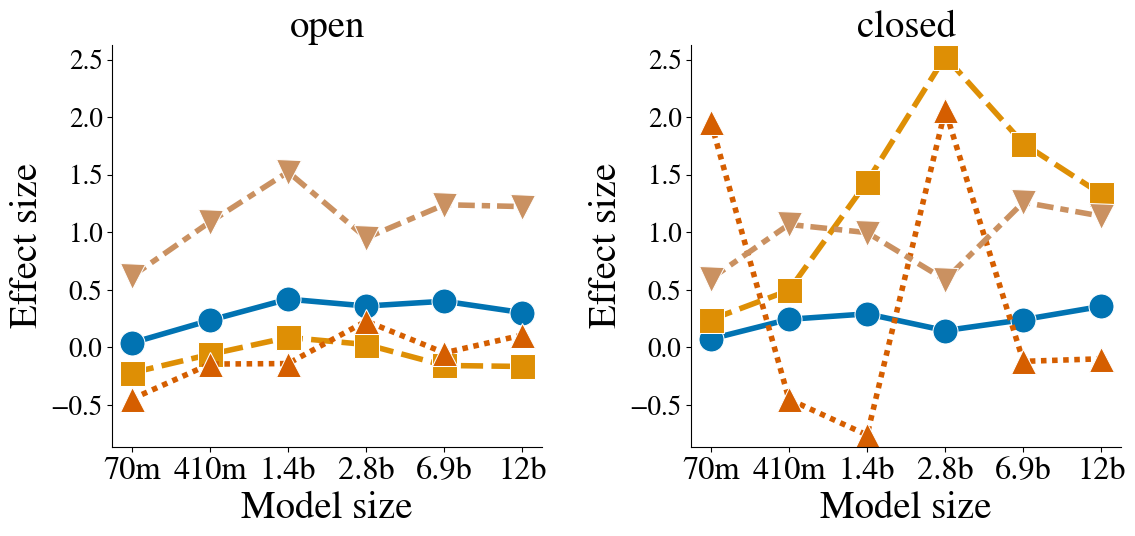

In [41]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i, qt in enumerate(
    sorted(all_effect_szs_combined_df["query_type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.lineplot(
        data=all_effect_szs_combined_df[all_effect_szs_combined_df["query_type"] == qt],
        x="Model size",
        y="mean_effect_sz",
        hue="Comparison",
        style="Comparison",
        markers=["o", "s", "^", "v"],
        markersize=18,  # 16
        linewidth=4,  # 3
        ax=ax,
        legend=None,
        # legend=None if i == 0 else True,
        palette=comparison_colormap,
    )
    ax.set_title(qt, size="medium")
    ax.set_xlabel("Model size", size="medium")
    ax.set_ylabel("Effect size", size="medium")
    ax.tick_params(axis="x", which="major", labelsize="small")
    ax.tick_params(axis="y", which="major", labelsize="x-small")
    ax.set_ylim(
        all_effect_szs_combined_df["mean_effect_sz"].min() - 0.1,
        all_effect_szs_combined_df["mean_effect_sz"].max() + 0.1,
    )

# fig.suptitle(
#     " ",
#     # "Mean effect size for different comparisons and models",
#     y=0.92,
# )
plt.tight_layout()
# plt.subplots_adjust(right=0.75)  # Adjust this value based on your figure size

plot_name = f"plot_comparisons_effect_szs_models_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [42]:
print(
    json.dumps(
        {k: matplotlib.colors.rgb2hex(v) for k, v in comparison_colormap.items()},
        indent=2,
    )
)

{
  "Familiar vs unfamiliar entities": "#0173b2",
  "Assertive vs base contexts": "#de8f05",
  "Negation vs base contexts": "#d55e00",
  "Relevant vs irrelevant contexts": "#ca9161"
}


This plot indicates, as measured by average effect size over queries, the degree to which (bronze down triangles) relevant contexts are more persuasive than irrelevant contexts, (blue circles) unfamiliar entities are more susceptible than familiar entities, (yellow squares) assertive contexts are more persuasive than base contexts, and (orange triangles) negation contexts are more persuasive than base contexts.

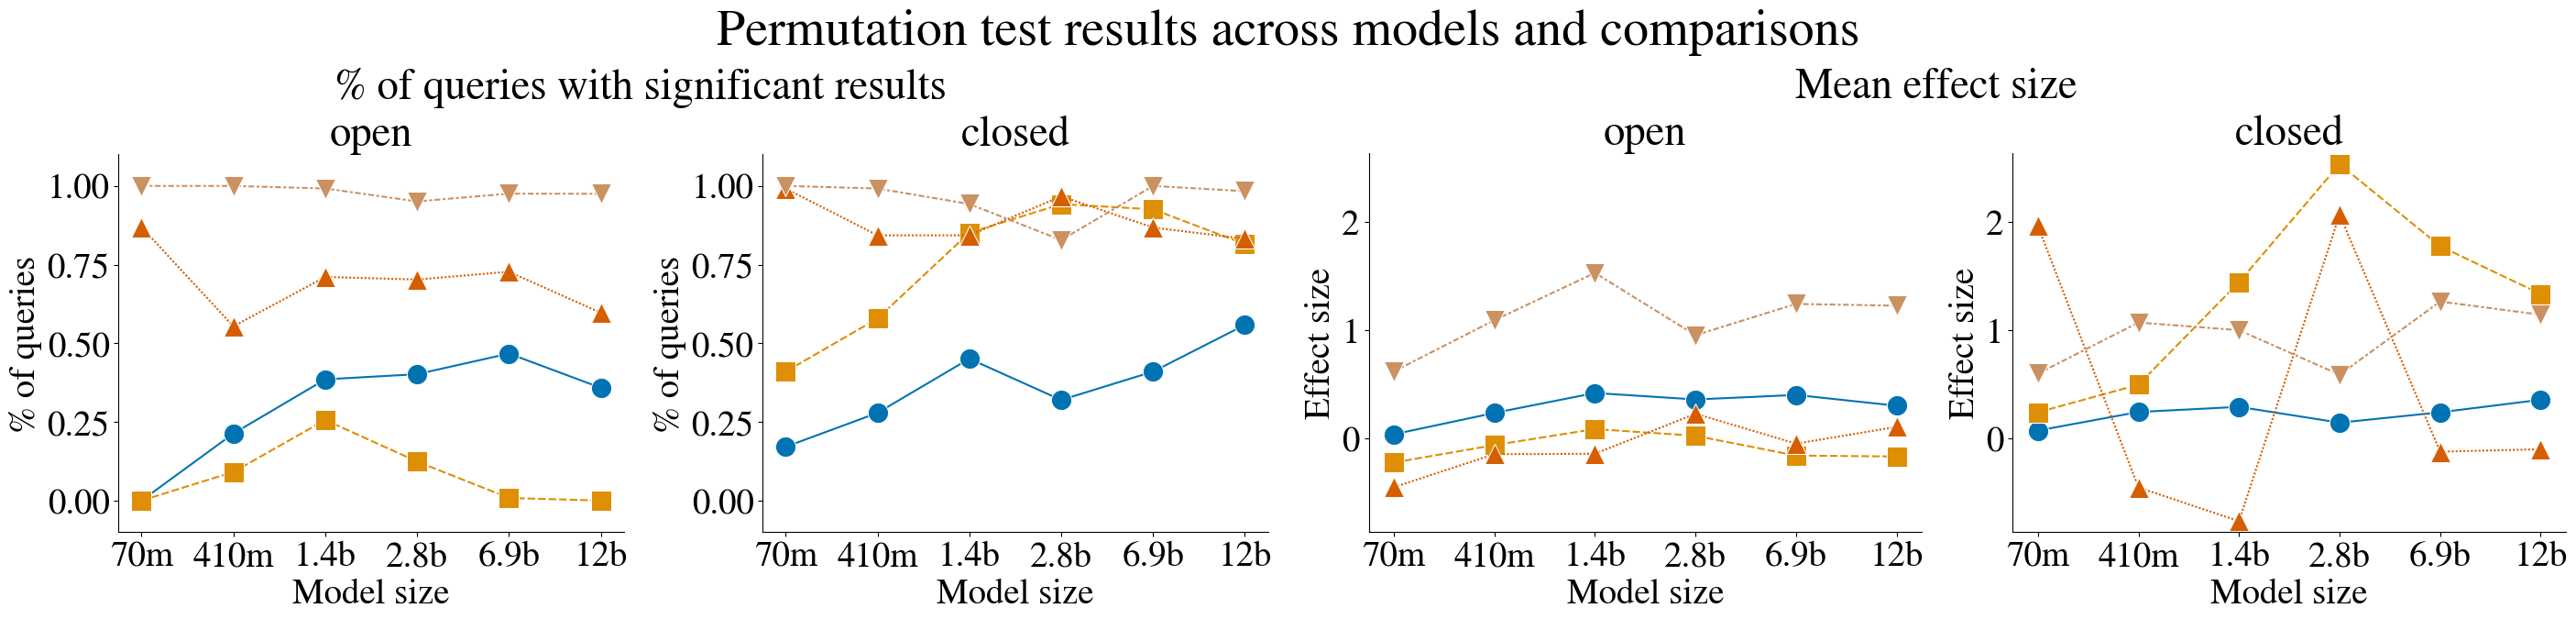

In [43]:
fig = plt.figure(constrained_layout=True, figsize=(28, 6))
subfigs = fig.subfigures(nrows=1, ncols=2)

axes = subfigs[0].subplots(nrows=1, ncols=2)
for i, qt in enumerate(
    sorted(all_tests_combined_df["Query type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.lineplot(
        data=all_tests_combined_df[all_tests_combined_df["Query type"] == qt],
        x="Model size",
        y="value",
        hue="Comparison",
        style="Comparison",
        markers=["o", "s", "^", "v"],
        markersize=16,
        ax=ax,
        legend=None,
        # legend=None if i == 0 else True,
        palette=comparison_colormap,
    )
    ax.set_title(qt)
    ax.set_xlabel("Model size")
    ax.set_ylabel("% of queries")
    ax.set_ylim(-0.1, 1.1)

subfigs[0].suptitle(
    "% of queries with significant results",
    # size="medium",
)

axes = subfigs[1].subplots(nrows=1, ncols=2)
for i, qt in enumerate(
    sorted(all_effect_szs_combined_df["query_type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.lineplot(
        data=all_effect_szs_combined_df[all_effect_szs_combined_df["query_type"] == qt],
        x="Model size",
        y="mean_effect_sz",
        hue="Comparison",
        style="Comparison",
        markers=["o", "s", "^", "v"],
        markersize=16,
        ax=ax,
        legend=None,
        # legend=None if i == 0 else True,
        palette=comparison_colormap,
    )
    ax.set_title(qt)
    ax.set_xlabel("Model size")
    ax.set_ylabel("Effect size")
    ax.set_ylim(
        all_effect_szs_combined_df["mean_effect_sz"].min() - 0.1,
        all_effect_szs_combined_df["mean_effect_sz"].max() + 0.1,
    )

subfigs[1].suptitle(
    "Mean effect size",
    # size="medium",
)

fig.suptitle(
    "Permutation test results across models and comparisons",
    y=1.1,
    size="x-large",
)

plot_name = f"plot_prop_sig_and_effect_szs_comparisons_models_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [44]:
for (_, ef_df), (_, prop_df) in zip(
    all_effect_szs_combined_df.groupby(["query_type", "Comparison"]),
    all_tests_combined_df.groupby(["Query type", "Comparison"]),
):
    ef_df = ef_df.rename(
        columns={"query_type": "Query type", "mean_effect_sz": "Mean effect size"}
    )
    ef_df_full = ef_df.copy()

    ef_df = ef_df[
        [
            "Model size",
            # "Comparison",
            # "Query type",
            "Mean effect size",
        ]
    ]
    # prop_df = prop_df.rename(columns={"value": "% relations with significant result"})
    prop_df = prop_df.rename(columns={"value": "% relations w/ sig. result"})
    prop_df = prop_df[prop_df["significance"] != "insignificant"][
        [
            "Model size",
            # "Comparison",
            # "Query type",
            "% relations w/ sig. result",
        ]
    ]
    print(
        f"{ef_df_full['Comparison'].iloc[0]}, {ef_df_full['Query type'].iloc[0]} queries"
    )
    print(prop_df.merge(ef_df).to_markdown(index=False, floatfmt=".2f"))
    # print(
    #     .to_markdown(index=False)
    # )
    print("\n\n")
    # print(prop_df)

Assertive vs base contexts, closed queries
| Model size   |   % relations w/ sig. result |   Mean effect size |
|:-------------|-----------------------------:|-------------------:|
| 70m          |                         0.41 |               0.24 |
| 410m         |                         0.58 |               0.50 |
| 1.4b         |                         0.85 |               1.44 |
| 2.8b         |                         0.94 |               2.53 |
| 6.9b         |                         0.93 |               1.77 |
| 12b          |                         0.82 |               1.33 |



Familiar vs unfamiliar entities, closed queries
| Model size   |   % relations w/ sig. result |   Mean effect size |
|:-------------|-----------------------------:|-------------------:|
| 70m          |                         0.17 |               0.07 |
| 410m         |                         0.28 |               0.24 |
| 1.4b         |                         0.45 |               0.29 |
| 2.8b   